### 3D Particle simulation, from H. Talbot

In [1]:
import matplotlib.pylab as plt
import numpy as np
import numpy.random
import scipy
import skimage
import pymrt as mrt
import raster_geometry as rg
#import pymrt.geometry


 ____        __  __ ____ _____
|  _ \ _   _|  \/  |  _ \_   _|
| |_) | | | | |\/| | |_) || |
|  __/| |_| | |  | |  _ < | |
|_|    \__, |_|  |_|_| \_\|_|
       |___/



In [2]:
# constants
def setParameters(shapeimg=350,# size of the image
                  radius=80, # radius of HR ball
                  step=0.1, # relative to 1
                  slices=7,# number of 2D samples
                  zoomfactor=0.1,
                  approxorder=1):
    return(shapeimg,radius,step,slices,zoomfactor,approxorder)

# globals, avoid using them
shapeimg,radius,step,slices,zoomfactor,approxorder = setParameters()

In [3]:
# perfect sphere
ball1=rg.sphere(shapeimg,radius,position=[0.5,0.7,0.7]).astype(float)
ball1.shape

(350, 350, 350)

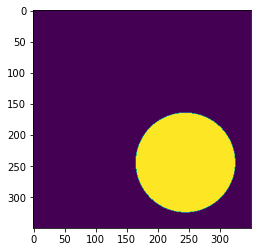

In [4]:
plt.figure()
plt.imshow(ball1[int(shapeimg/2),:,:])
plt.show()

In [5]:
## Random placement, then downsample
center=np.random.normal(loc=0.5,scale=step,size=3)

In [6]:
ball1=rg.sphere(shapeimg,radius,position=center).astype(float)
print("center=",center)

center= [0.53507092 0.53556059 0.45434361]


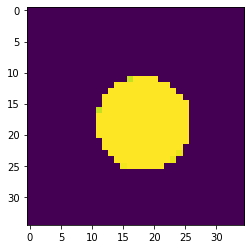

In [7]:
from scipy.ndimage.interpolation import zoom
smallball1=zoom(ball1,zoomfactor,order=1)
plt.figure()
plt.imshow(zoom(ball1[:,:,int(shapeimg*0.4)],zoomfactor,order=1))
plt.show()

In [8]:
import logging, sys
logging.basicConfig(stream=sys.stderr, level=logging.DEBUG)
#logging.debug('A debug message!')
#logging.info('We processed %d records', len(processed_records))

def sampleBall(debug=True):
    # parameters as local variables
    shapeimg,radius,step,slices,zoomfactor,approxorder = setParameters()
    
    n=slices
    slicelist = ((np.arange(n)-(n-1)/2)*(2*radius/n)+(shapeimg/2)).astype(int)
    logging.debug("slicelist=%s",str(slicelist))
    disklist = []
    centers = []
    for i in range(n):
        # create high resolution ball randomly shifted
        center=np.random.normal(loc=0.5,scale=step,size=3)
        logging.debug("center=%s",str(center))
        hrBall=rg.sphere(shapeimg,radius,position=center).astype(float)
        lrDisk=zoom(hrBall[slicelist[i],:,:],zoomfactor,order=approxorder)
        disklist.append(lrDisk)
        centers.append(center)
    return(centers,slicelist, np.array(disklist))

DEBUG:root:slicelist=[106 129 152 175 197 220 243]
DEBUG:root:center=[0.48858669 0.51889971 0.53657704]
DEBUG:root:center=[0.50196954 0.67949501 0.48596246]
DEBUG:root:center=[0.55862588 0.4354263  0.52255964]
DEBUG:root:center=[0.53832089 0.59119436 0.4515405 ]
DEBUG:root:center=[0.34890711 0.42873546 0.56969513]
DEBUG:root:center=[0.57886786 0.41228359 0.55301598]
DEBUG:root:center=[0.35830202 0.54466025 0.61001078]


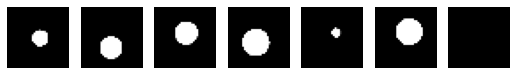

In [9]:
centers,slicelist,mysamples=sampleBall()
def imshown(imlist,cmap="gray"):
    w=10
    h=10
    fig=plt.figure(figsize=(9, 2))
    columns = len(imlist)
    rows = 1
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(imlist[i-1],cmap=cmap)
        plt.axis('off')

    plt.show()
    
imshown(mysamples,cmap="gray")

## Simulation and estimation

(350, 350, 350)


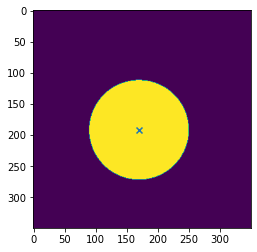

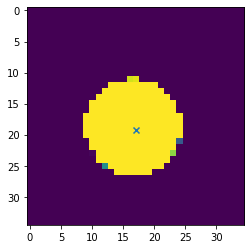

In [10]:
# Parameters

# Dimension of the 3D image
Nx,Ny,Nz = (350,350,350)

# Radius and center of the sphere
Radius = 80
np.random.seed(42)
center=np.random.normal(loc=0.5,scale=step,size=3)

# Particle simulation
# perfect sphere
ball =rg.sphere((Nx,Ny,Nz),Radius,position=center).astype(float)
print(ball.shape)

# Zoom
# Zoom factor
zoomfactor = 0.1
nx = int(zoomfactor*Nx)
ny = int(zoomfactor*Ny)
nz = int(zoomfactor*Nz)
R = Radius*zoomfactor


from scipy.ndimage.interpolation import zoom

particle = zoom(ball,zoomfactor,order=1)

plt.figure()
plt.imshow(ball[:,:,int(Nz*center[2])])
plt.scatter([Nx*center[1]],[Ny*center[0]], marker="x")
plt.show()


plt.figure()
plt.imshow(particle[:,:,int(nz*center[2])])
plt.scatter([nx*center[1]],[ny*center[0]], marker="x")
plt.show()

# Diagonal of the frames
d = np.sqrt(nx**2+ny**2)

# z-coordinates of the frames
frames  = np.arange(0,nz)
# Number of frames
m = len(frames)


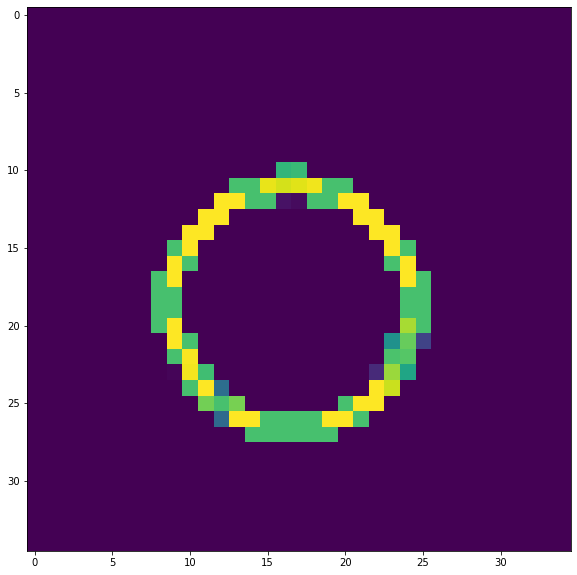

In [11]:
# Total variation 3D matrix of the image frames
def W_mat(image, frames):
    nx,ny,nz = image.shape
    nz = len(frames)
    W = np.zeros((nx,ny,nz))
    for i in range(nx):
        for j in range(ny):
            k_translated = 0
            for k in frames:
                varX = 0
                varY = 0
                if i==0:
                    varX += (image[i+1,j,k]-image[i,j,k])**2
                elif i==nx-1:
                    varX += (image[i-1,j,k]-image[i,j,k])**2
                else:
                    varX += (image[i-1,j,k]-image[i,j,k])**2+(image[i+1,j,k]-image[i,j,k])**2
                if j==0:
                    varY += (image[i,j+1,k]-image[i,j,k])**2
                elif j==ny-1:
                    varY += (image[i,j-1,k]-image[i,j,k])**2
                else:
                    varY += (image[i,j-1,k]-image[i,j,k])**2+(image[i,j+1,k]-image[i,j,k])**2
                W[i,j,k_translated] = np.sqrt(varX+varY)
                k_translated +=1
    return W


plt.figure(figsize=(15,10))
plt.imshow(W_mat(particle,frames)[:,:,int(nz*center[2])])


In [12]:
# Objective function
def objective_function(image,frames):
    nx,ny,nz = image.shape
    m = len(frames)
    W = W_mat(image,frames)
    def obj(alpha,beta,gamma,xi,eta):
        res = 0
        for k in range(m):
            for i in range(nx):
                for j in range(ny):
                    res += W[i,j,frames[k]]*(-2*i*alpha -2*j*beta + xi - eta[k] +i**2+j**2)**2
        return res/2
    return obj



obj = objective_function(particle,frames)
print(obj(10,10,10,10,np.ones(m)))

7311993.319739506


In [13]:
# Keeping only frames intersecting the sphere

def intersecting_frames(image,frames):
    start = -1
    end = -1
    index = 0
    m = len(frames)
    while end<0 and index<m:
        M = np.amax(image[:,:,frames[index]])
        if M>0 and start<0:
            start = index
        if start >= 0 and M==0:
            end = index
        index+=1
    if end<0:
        end = m
    return frames[start:end]

print(intersecting_frames(particle, frames))
print(np.amax(particle[:,:,11]))
print(np.amax(particle[:,:,12]))


framesInter = intersecting_frames(particle, frames)
mInter = len(framesInter)
print(mInter)


[12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
0.0
1.0
15


In [14]:
# Problem with cvxpy
import cvxpy as cp

# Variables

alpha = cp.Variable(1)
beta = cp.Variable(1)
gamma = cp.Variable(1)
xi = cp.Variable(1)
eta = cp.Variable(mInter)

# Objective
obj = objective_function(particle,framesInter)

objective = cp.Minimize(obj(alpha,beta,gamma,xi,eta))

# Constraints
constraints = [alpha**2+beta**2-xi <= 0, xi - d**2 <= 0, -eta <= 0, eta+(gamma-framesInter)**2 - R**2 <= 0]


# Problem
prob = cp.Problem(objective,constraints)


IndexError: index 15 is out of bounds for axis 2 with size 15

In [ ]:
# Solving
prob.solve(solver = cp.ECOS, verbose = True, max_iters=100)

print("Optimal value", prob.value)
print("Status :", prob.status)

print("alpha = ", alpha.value) 
print("beta = ", beta.value) 
print("gamma = ", gamma.value) 

print("Real center: ", center*nx)

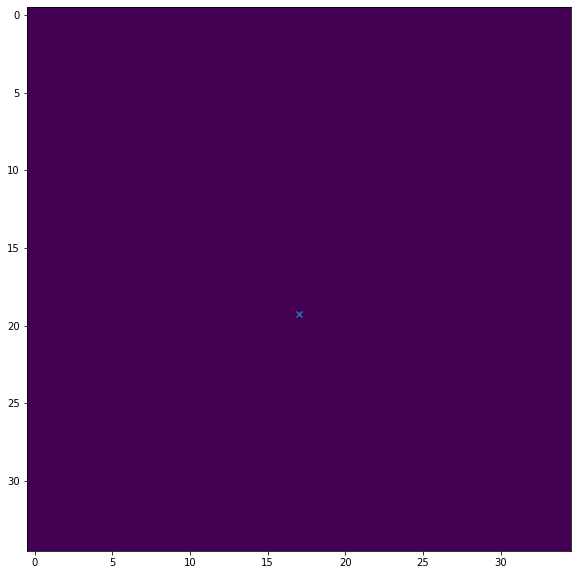

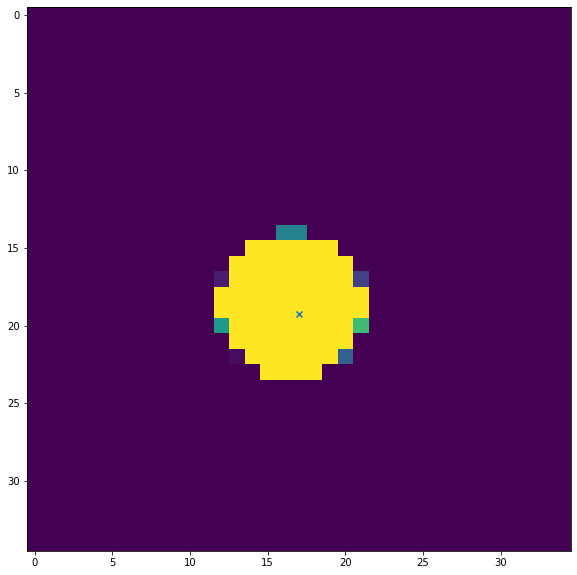

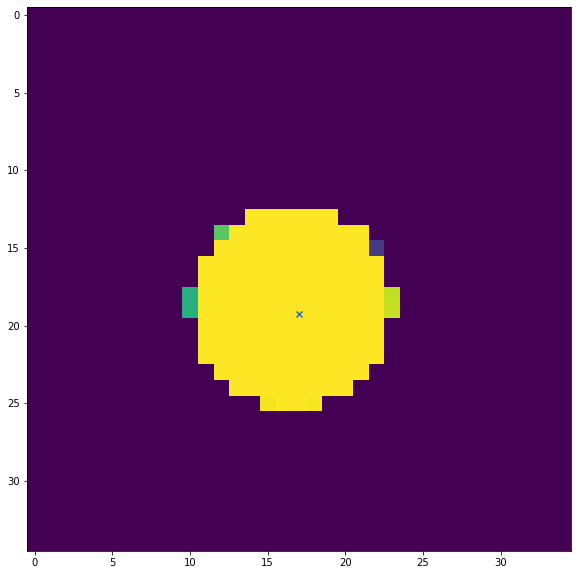

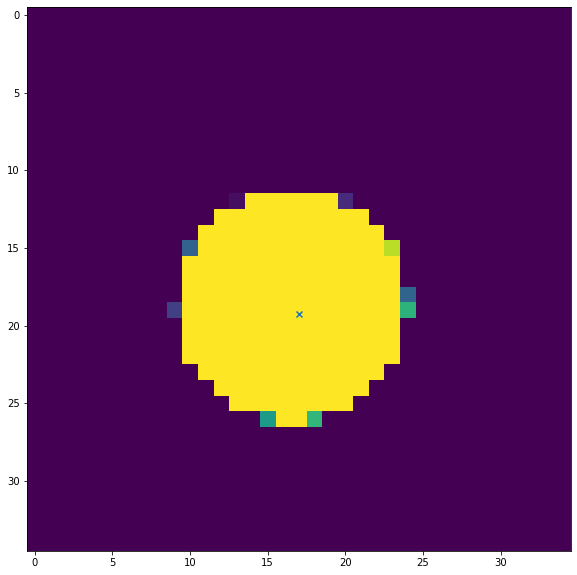

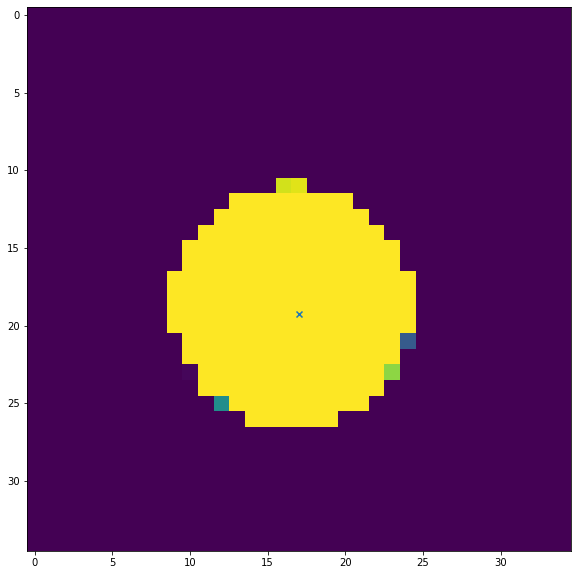

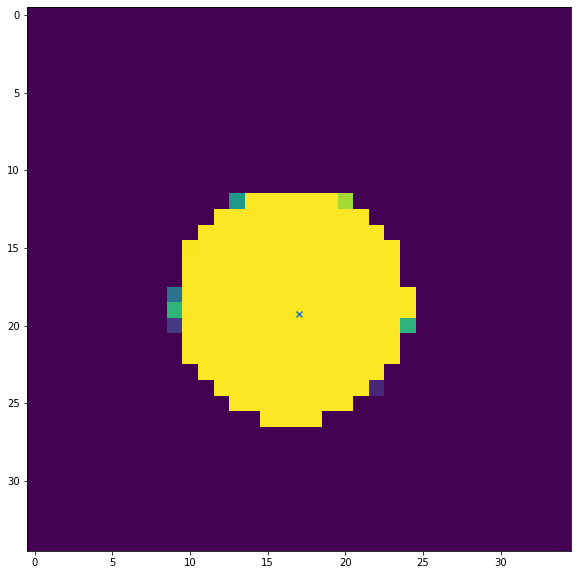

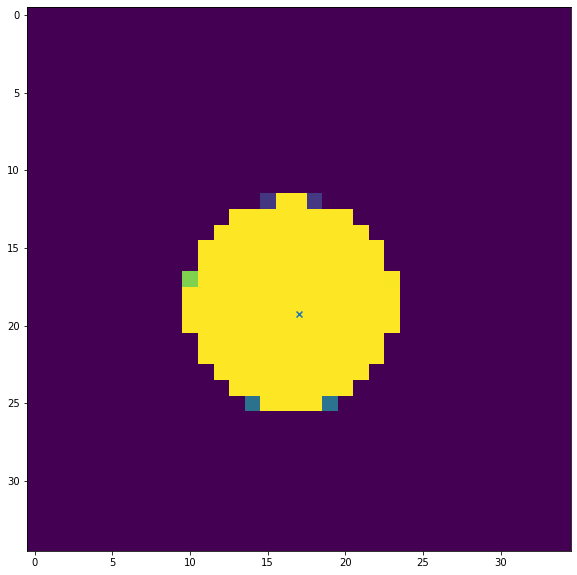

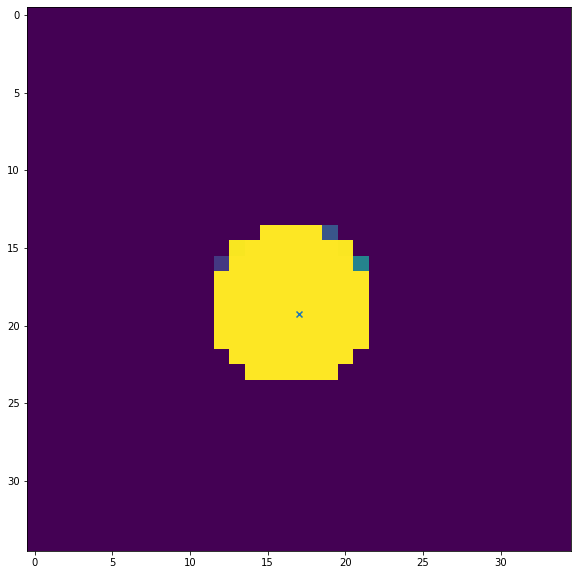

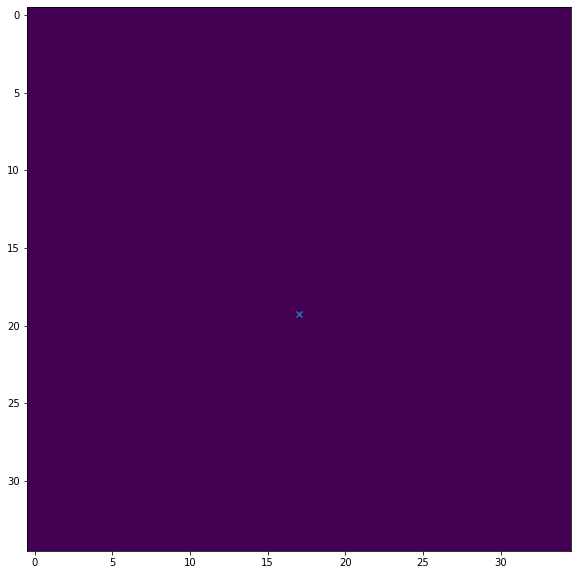

In [15]:
Z = int(nz*center[2])

for i in range(-8,9,2):
    plt.figure(figsize=(20,10))
    plt.imshow(particle[:,:,Z+i])
    plt.scatter([nx*center[1]],[ny*center[0]], marker="x")
    plt.scatter([beta.value],[alpha.value], marker="x", color='red')
    plt.show()

In [16]:
def Create_A_and_b(W):
    "Cette fonction permet de creer la matrice A de taille n * 4+m et le vecteur b de taille n"
    
    #Convertir la matrice W en 2D -- Taille: n * s(3) avec n = s(1)*s(2)
    s1 = np.size(W,0)
    s2 = np.size(W,1)
    s3 = np.size(W,2)
    
    W_2D = W.reshape(s1*s2, s3)

#Definir le vecteur f_1 de taille 4+m (vecteur de 0 sauf le 1er element est 1)    
    f_1 = np.zeros((4+s3,1))
    f_1[0] = 1   
    
#Definir le vecteur f_2 de taille 4+m (vecteur de 0 sauf le 2eme element est 1)
    f_2 = np.zeros((4+s3,1))
    f_2[1] = 1    
    
#Definir le vecteur f_3 de taille 4+m (vecteur de 0 sauf le 3eme element est 1)
    f_3 = np.zeros((4+s3,1))
    f_3[3] = 1    

#Definir le vecteur f_{4+i} de taille 4+m (vecteur de 0 sauf le (4+i)th element est 1)
    f_4_i = np.zeros((4+s3,1))   
    
# Definir les vecteurs x et y de taille n chacun
    x = np.zeros((s1*s2,1))
    y = np.zeros((s1*s2,1))
    for jj in range(s1*s2):
        x[jj] = np.floor((jj)/s1)
        y[jj] = np.mod(jj,s1)

        
#Definir un vecteur unite de taille n
    vecteur_unitaire = np.ones((s1*s2,1));    
        
    A = np.zeros((np.size(W_2D, 0), 4+s3, s3))
    b = np.zeros((np.size(W_2D, 0), s3));
    
    listA = [] #empty listA
    listb = []  #empty listb
    
    for kk in range(s3):
        f_4_i[4+kk] = 1
        A[:, :, kk] = np.diag(np.sqrt(W_2D[:, kk])) .dot(-2*np.kron(np.transpose(f_1), x) - 2*np.kron(np.transpose(f_2), y) + np.kron(np.transpose(f_3), vecteur_unitaire) - np.kron(np.transpose(f_4_i), vecteur_unitaire))
        listA.append(A[:, :, kk])
        
        b[:, kk] = np.multiply(-np.sqrt(W_2D[:, kk]), np.transpose(x**2)) + np.multiply(-np.sqrt(W_2D[:, kk]), np.transpose(y**2))
        listb.append(b[:, kk])
        
          
   #Concatenation dans une grande matrice (c'est important pour CVX)           
    permuted_A = np.transpose(A, (0, 2, 1))
    matrice_A = permuted_A.reshape(np.size(W_2D,0)*s3, 4+s3)
    vecteur_b = b.reshape(np.size(b,0) * np.size(b,1))
    
    return matrice_A, vecteur_b, listA, listb



## Methode de Newton

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# Centering step

# fonction à minimiser
def fct(listA, listb):
    m = len(listA)
    def f(v): 
        return np.sum([np.linalg.norm(listA[i]@v - listb[i])**2 for i in range(m)])/2
    return f

# v = np.concatenate((alpha, beta, gamma, xsi, eta))


# Fonction avec barrière:
def fct_bar(listA, listb, z, R, d, t): # t est le paramètre de barrière
    m = len(listA)
    def f(v):
        constr1 = v[4:]
        constr2 = -(v[4:] + (v[2]-z)**2 - R**2)
        constr3 = [-(v[0]**2 + v[1]**2 - v[3])]
        constr4 = [-(v[3] - d**2)]
        constr = np.concatenate((constr1,constr2,constr3,constr4))
        if np.min(constr) <= 0:
            #raise NameError("v non admissible")
            return np.inf
        else:
            return np.sum([np.linalg.norm(listA[i]@v - listb[i])**2 for i in range(m)])/2 - (1/t)*np.sum(np.log(constr))
    return f



# Gradient en v de la fonction à minimiser
def grad_f(listA, listb, z, R, d, t, v):
    n = len(v)
    m = len(listA)
    res = np.sum([listA[i].T@(listA[i]@v - listb[i]) for i in range(m)], axis=0)
    bar = np.zeros(n)
    # terme dû à la fonction barrière pour constr3 et constr4
    x = (-(v[0]**2 + v[1]**2 - v[3]))
    bar[0] += -2*v[0]/x
    bar[1] += -2*v[1]/x
    bar[3] += 1/x - 1/(d**2-v[3])
    for j in range(4,n):
        u = v[j]
        # terme dû à la fonction barrière pour constr1 et constr2
        x = R**2 - u - (v[2]-z[j-4])**2
        bar[2] += -2*(v[2]-z[j-4])/x
        bar[j] += 1/u - 1/x  
    return res - bar/t



# Hessienne
def hess_f(listA, listb, z, R, d, t, v):
    n = len(v)
    m = len(listA)
    res = np.sum([listA[i].T@listA[i] for i in range(m)], axis=0)
    bar = np.zeros((n,n))
    x = (v[0]**2 + v[1]**2 - v[3])**2
    bar[0,0] += (-2*(v[3] - v[0]**2 - v[1]**2) - 4*v[0]**2)/x
    bar[1,1] += (-2*(v[3] - v[0]**2 - v[1]**2) - 4*v[1]**2)/x
    bar[3,3] += -1/x - 1/(v[3]-d**2)**2
    b = -4*v[0]*v[1]/x
    bar[0,1] += b
    bar[1,0] += b
    b = 2*v[0]/x
    bar[0,3] += b
    bar[3,0] += b
    b = 2*v[1]/x
    bar[1,3] += b
    bar[3,1] += b
    for j in range(4,n):
        u = v[j]
        # terme dû à la fonction barrière pour constr1 et constr2
        x = (R**2 - u - (v[2]-z[j-4])**2)**2
        bar[2,2] += (-2*(R**2 - u - (v[2]-z[j-4])**2) - 4*(v[2]-z[j-4])**2)/x
        bar[j,j] += -1/u**2 - 1/x
        b = 2*(v[2]-z[j-4])/x
        bar[2,j] += b
        bar[j,2] += b
    return  res - bar/t





# Backtracking line search
def lineSearch(f,x,delta,grad,alpha,beta,t=1): # 0<alpha<1/2 et 0<beta<1
    while f(x+t*delta) >= f(x) + alpha*t*(grad.T@delta) :
        t = beta*t
    return t

def graddesc(f,v,grad, t=1000):
    crit = True
    while crit:
        if f(v - t*grad) < f(v):
            v = v - t*grad
            crit = False
        t = t/2
    return v

# Centering step
# On retourne la liste des points et des decr pour les graphes à la fin
def centering_step(listA, listb, z, R, d, t, v0, crit, alpha = 0.4, beta = 0.9): # t et eps > 0
    # méthode de Newton
    res = [v0]
    v = v0
    decr = np.inf
    liste_decr=[]
    f = fct_bar(listA, listb, z, R, d, t)
    grad = grad_f(listA, listb, z, R, d, t, v)
    hess = hess_f(listA, listb, z, R, d, t, v)
    hess_inv = np.linalg.inv(hess)
    delta = -hess_inv@grad
    decr = grad.T@hess_inv@grad
    #print("decr = ",decr)
    #print(np.linalg.norm(grad))
    #while np.linalg.norm(grad) > crit:
    while decr/2 >= crit:
        v = v + lineSearch(f,v,delta,grad,alpha,beta)*delta
        #v = graddesc(f,v,grad)
        res.append(v)
        grad = grad_f(listA, listb, z, R, d, t, v)
        hess = hess_f(listA, listb, z, R, d, t, v)
        hess_inv = np.linalg.inv(hess)
        delta = -hess_inv@grad
        decr = grad.T@hess_inv@grad
        liste_decr.append(decr)
        #print("decr = ",decr)
        #print(delta)
        #print("v_cent = ",v)
        #print("f_bar(v_cent) = ",f(v))
    return (res,liste_decr)


# Barrier method
# On retourne la liste des points et des decr pour les graphes à la fin
def barr_method(listA, listb, z, R, d, v0,eps, crit, alpha =0.4, beta = 0.9, t0 = 1, mu = 10): # t0, mu et eps > 0
    res = [v0]
    liste_decr = []
    n = len(v0)
    v = v0
    t = t0
    while n/t >= eps:
        #print("v = ",v)
        print("f(v) = ",fct(listA,listb)(v))
        (v, liste_decr_centering) = centering_step(listA, listb, z, R, d, t, v,crit, alpha, beta)
        liste_decr+= liste_decr_centering
        t = mu*t
        res = res + v
        v = v[-1]
    return (res,liste_decr)

In [56]:
#test

n = 8
listA = [np.eye(n)]

#listA[0][2,2]=0
#listA[0][0,0]=0
#listA[0][1,1]=0
b = np.ones(n)*10
b[3] = 210


listb = [b]
R=np.sqrt(110)+1
d=15
z = np.zeros(n-4)
v0 = np.ones(n)*6
v0[3]=150

eps=1e-6
crit=1e-6

v=barr_method(listA, listb, z, R, d, v0,eps,crit,t0=1,mu=10)[0][-1]
print(v)

f(v) =  1856.0000000000002
f(v) =  1.3588514673485175
f(v) =  0.05686223620029223
f(v) =  0.0009638310625902459
f(v) =  1.0478317508114051e-05
f(v) =  1.0620568034458656e-07
f(v) =  1.0620568034458656e-07
[  9.99980017   9.99980017   9.99963611 210.00000332  10.00000548
  10.00000548  10.00000548  10.00000548]


DEBUG:matplotlib.ticker:vmin 3.74728637035672e-07 vmax 5373.2620797900545
DEBUG:matplotlib.ticker:ticklocs array([1.e-09, 1.e-07, 1.e-05, 1.e-03, 1.e-01, 1.e+01, 1.e+03, 1.e+05,
       1.e+07])
DEBUG:matplotlib.ticker:vmin 3.74728637035672e-07 vmax 5373.2620797900545
DEBUG:matplotlib.ticker:ticklocs array([1.e-09, 1.e-07, 1.e-05, 1.e-03, 1.e-01, 1.e+01, 1.e+03, 1.e+05,
       1.e+07])
DEBUG:matplotlib.ticker:vmin 3.74728637035672e-07 vmax 5373.2620797900545
DEBUG:matplotlib.ticker:ticklocs array([1.e-09, 1.e-07, 1.e-05, 1.e-03, 1.e-01, 1.e+01, 1.e+03, 1.e+05,
       1.e+07])
DEBUG:matplotlib.ticker:vmin 3.74728637035672e-07 vmax 5373.2620797900545
DEBUG:matplotlib.ticker:ticklocs array([], dtype=float64)
DEBUG:matplotlib.font_manager:findfont: Matching STIXGeneral:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_mana

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Didot' (Didot.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (Arial Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Mishafi Gold' (Mishafi Gold.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W3.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Lepcha' (NotoSansLepcha-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Galvji' (Galvji.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (Arial.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W6.ttc) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'N

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Serif Myanmar' (NotoSerifMyanmar.ttc) normal normal black normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Chalkduster' (Chalkduster.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Zapfino' (Zapfino.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Black.otf) normal normal black condensed>) = 10.725
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (Arial Bold Italic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille Pinpoint 6 Dot.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Tai Le' (NotoSansTaiLe-Regular.

f(v) =  1856.0000000000002
f(v) =  1.3588514673485175
f(v) =  0.33447022737860577
f(v) =  0.0671053752593564
f(v) =  0.010769677895397387
f(v) =  0.0014170248194914985
f(v) =  0.00017207958204164232
f(v) =  1.9710064402145227e-05
f(v) =  2.2120301085713437e-06
f(v) =  2.2120301085713437e-06
f(v) =  2.742896687756784e-08
f(v) =  2.742896687756784e-08
f(v) =  2.742896687756784e-08
f(v) =  2.742896687756784e-08
f(v) =  2.742896687756784e-08
f(v) =  1856.0000000000002
f(v) =  1.3588514673485175
f(v) =  0.16298025815471295
f(v) =  0.012322987383978926
f(v) =  0.0006118488938209502
f(v) =  2.671012191161618e-05
f(v) =  1.0849377687433563e-06
f(v) =  1.0849377687433563e-06
f(v) =  1.0849377687433563e-06
f(v) =  6.967844418486907e-11
f(v) =  1856.0000000000002
f(v) =  1.3588514673485175
f(v) =  0.05686223620029223
f(v) =  0.0009638310625902459
f(v) =  1.0478317508114051e-05
f(v) =  1.0620568034458656e-07
f(v) =  1.0620568034458656e-07
f(v) =  1856.0000000000002
f(v) =  1.3588514673485175
f(v) 

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Myanmar' (NotoSansMyanmar.ttc) normal normal black normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Charter' (Charter.ttc) normal normal roman normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Bold.otf) normal normal bold condensed>) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Medium.otf) normal normal medium condensed>) = 10.344999999999999
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Avenir' (Avenir.ttc) normal normal book normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'ITF Devanagari' (ITFDevanagari.ttc) normal normal book normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lao Sangam MN' (Lao Sangam MN.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Tai Tham' (NotoSansTa

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Tifinagh' (NotoSansTifinagh-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.LastResort' (LastResort.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Cypriot' (NotoSansCypriot-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Ol Chiki' (NotoSansOlChiki-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times New Roman' (Times New Roman Italic.ttf) italic normal roman normal>) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Iowan Old Style' (Iowan Old Style.ttc) normal normal roman normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ari

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Carian' (NotoSansCarian-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUpD' (STIXIntUpDReg.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sathu' (Sathu.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bangla Sangam MN' (Bangla Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gurmukhi MT' (Gurmukhi.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Symbol' (Symbol.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Rockwell' (Rockwell.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Gothic' (NotoSansGothic-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.f

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Marker Felt' (MarkerFelt.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Helvetica Neue' (HelveticaNeue.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille Outline 6 Dot.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Microsoft Sans Serif' (Microsoft Sans Serif.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Avenir Next' (Avenir Next.ttc) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Muna' (Muna.ttc) normal normal regular normal>) = 10.

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Imperial Aramaic' (NotoSansImperialAramaic-Regular.ttf) normal normal regular normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Inscriptional Pahlavi' (NotoSansInscriptionalPahlavi-Regular.ttf) normal normal regular normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W0.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUpD' (STIXIntUpDBol.otf) normal normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Unicode MS' (Arial Unicode.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kannada MN' (Kannada MN.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsD' (STIXIntDReg.otf) normal normal regular normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'And

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kefa' (Kefa.ttc) normal normal regular normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUpSm' (STIXIntUpSmReg.otf) normal normal regular normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Mshtakan' (Mshtakan.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gurmukhi MN' (Gurmukhi MN.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kohinoor Telugu' (KohinoorTelugu.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W2.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'PT Sans' (PTSans.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Skia' (Skia.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DIN Alterna

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Devanagari Sangam MN' (Devanagari Sangam MN.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Armenian' (NotoSansArmenian.ttc) normal normal black normal>) = 11.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Al Bayan' (AlBayan.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Georgia' (Georgia Italic.ttf) italic normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bodoni 72 Oldstyle' (Bodoni 72 OS.ttc) normal normal book normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bradley Hand' (Bradley Hand Bold.ttf) normal normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.otf) normal normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Diwan Thuluth' (Diwan Thuluth.ttf) normal normal regular normal>)

DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Light.otf) normal normal light condensed>) = 11.44
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Serif Balinese' (NotoSerifBalinese-Regular.ttf) normal normal regular normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New Bold Italic.ttf) italic normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hoefler Text' (Hoefler Text.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Old South Arabian' (NotoSansOldSouthArabian-Regular.ttf) normal normal regular normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W4.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Baskerville' (Baskerville.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'PT 

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Javanese' (NotoSansJavanese-Regular.otf) normal normal regular normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lucida Grande' (LucidaGrande.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.otf) normal normal regular normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Samaritan' (NotoSansSamaritan-Regular.ttf) normal normal regular normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Mono' (SFNSMono.ttf) normal normal light normal>) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUpSm' (STIXIntUpSmBol.otf) normal normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Damascus' (Damascus.ttc) normal normal regular normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Savoye LET' (Savoye LET.ttc) normal no

DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal regular normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal regular normal>) = 0.33499999999999996
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal 

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W6.ttc) normal normal 700 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Runic' (NotoSansRunic-Regular.ttf) normal normal regular normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'InaiMathi' (InaiMathi-MN.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Narrow' (Arial Narrow Bold.ttf) normal normal 700 condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Heiti TC' (STHeiti Light.ttc) normal normal light normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Geeza Pro' (GeezaPro.ttc) normal normal regular normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Helvetica' (Helvetica.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bodoni 72 Smallcaps' (Bodoni 72 Smallcaps Book.ttf) normal normal book normal>) = 1

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille Pinpoint 6 Dot.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Tai Le' (NotoSansTaiLe-Regular.ttf) normal normal regular normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Lydian' (NotoSansLydian-Regular.ttf) normal normal regular normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsD' (STIXIntDBol.otf) normal normal 700 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Limbu' (NotoSansLimbu-Regular.ttf) normal normal regular normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Verdana' (Verdana.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Ogham' (NotoSansOgham-Regular.ttf) normal normal regular normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Zapf Dingbats' (Zap

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New Bold.ttf) normal normal 700 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans GB' (Hiragino Sans GB.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Euphemia UCAS' (EuphemiaCAS.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Buginese' (NotoSansBuginese-Regular.ttf) normal normal regular normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Optima' (Optima.ttc) normal normal regular normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Kaithi' (NotoSansKaithi-Regular.ttf) normal normal regular normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Comic Sans MS' (Comic Sans MS.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sinhala MN' (Sinhala MN.ttc) normal normal 400 no

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Avenir Next Condensed' (Avenir Next Condensed.ttc) normal normal 700 condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (Arial Bold.ttf) normal normal 700 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noteworthy' (Noteworthy.ttc) normal normal light normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Cuneiform' (NotoSansCuneiform-Regular.ttf) normal normal regular normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tahoma' (Tahoma Bold.ttf) normal normal 700 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Wingdings 3' (Wingdings 3.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Bold.otf) normal normal bold condensed>) = 10.2
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Ugaritic' (NotoSansUgaritic-Regula

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Symbols' (Apple Symbols.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tahoma' (Tahoma.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Webdings' (Webdings.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Palatino' (Palatino.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Big Caslon' (BigCaslon.ttf) normal normal medium normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Mandaic' (NotoSansMandaic-Regular.ttf) normal normal regular normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DIN Condensed' (DIN Condensed Bold.ttf) normal normal 700 condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Chakma' (NotoSansChakma-Regular.ttf) normal normal regular normal>) = 10.335
DEBUG:

DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal 700 normal>) = 0.33499999999999996
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.t

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Khmer MN' (Khmer MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans New Tai Lue' (NotoSansNewTaiLue-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Heavy.otf) normal normal heavy condensed>) = 10.629999999999999
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Regular.otf) normal normal regular condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Malayalam MN' (Malayalam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Bamum' (NotoSansBamum-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Oriya MN' (Oriya MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<F

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Copperplate' (Copperplate.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Myanmar' (NotoSansMyanmar.ttc) normal normal black normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Charter' (Charter.ttc) normal normal roman normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Bold.otf) normal normal bold condensed>) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Medium.otf) normal normal medium condensed>) = 10.344999999999999
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Avenir' (Avenir.ttc) normal normal book normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'ITF Devanagari' (ITFDevanagari.ttc) normal normal book normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lao Sangam MN' (Lao Sangam MN.ttf) 

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Linear B' (NotoSansLinearB-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Tifinagh' (NotoSansTifinagh-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.LastResort' (LastResort.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Cypriot' (NotoSansCypriot-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Ol Chiki' (NotoSansOlChiki-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times New Roman' (Times New Roman Italic.ttf) italic normal roman normal>) = 11.145
DEBUG:matplotlib.font_manager:findfont: scor

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Rounded MT Bold' (Arial Rounded Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Carian' (NotoSansCarian-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUpD' (STIXIntUpDReg.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sathu' (Sathu.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bangla Sangam MN' (Bangla Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gurmukhi MT' (Gurmukhi.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Symbol' (Symbol.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Rockwell' (Rockwell.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.fo

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Marker Felt' (MarkerFelt.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Helvetica Neue' (HelveticaNeue.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille Outline 6 Dot.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Microsoft Sans Serif' (Microsoft Sans Serif.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Avenir Next' (Avenir Next.ttc) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New Italic.ttf) italic normal 400 norm

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ayuthaya' (Ayuthaya.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Imperial Aramaic' (NotoSansImperialAramaic-Regular.ttf) normal normal regular normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Inscriptional Pahlavi' (NotoSansInscriptionalPahlavi-Regular.ttf) normal normal regular normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W0.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUpD' (STIXIntUpDBol.otf) normal normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Unicode MS' (Arial Unicode.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kannada MN' (Kannada MN.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsD' 

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gujarati Sangam MN' (Gujarati Sangam MN.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kefa' (Kefa.ttc) normal normal regular normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUpSm' (STIXIntUpSmReg.otf) normal normal regular normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Mshtakan' (Mshtakan.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gurmukhi MN' (Gurmukhi MN.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kohinoor Telugu' (KohinoorTelugu.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W2.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'PT Sans' (PTSans.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfo

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Chalkboard' (Chalkboard.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Yi' (NotoSansYi-Regular.ttf) normal normal regular normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Devanagari Sangam MN' (Devanagari Sangam MN.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Armenian' (NotoSansArmenian.ttc) normal normal black normal>) = 11.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Al Bayan' (AlBayan.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Georgia' (Georgia Italic.ttf) italic normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bodoni 72 Oldstyle' (Bodoni 72 OS.ttc) normal normal book normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bradley Hand' (Bradley Hand Bold.ttf) normal normal bold normal>) = 11

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Diwan Kufi' (Diwan Kufi.ttc) normal normal regular normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Kayah Li' (NotoSansKayahLi-Regular.ttf) normal normal regular normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Light.otf) normal normal light condensed>) = 11.44
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Serif Balinese' (NotoSerifBalinese-Regular.ttf) normal normal regular normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New Bold Italic.ttf) italic normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hoefler Text' (Hoefler Text.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Old South Arabian' (NotoSansOldSouthArabian-Regular.ttf) normal normal regular normal>) = 11.05
DEBUG:matplotlib.font_manager:find

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Unicode MS' (Arial Unicode.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Regular.otf) normal normal regular condensed>) = 11.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Javanese' (NotoSansJavanese-Regular.otf) normal normal regular normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lucida Grande' (LucidaGrande.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.otf) normal normal regular normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Samaritan' (NotoSansSamaritan-Regular.ttf) normal normal regular normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Mono' (SFNSMono.ttf) normal normal light normal>) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXInte

DEBUG:matplotlib.font_manager:findfont: Matching STIXNonUnicode:style=normal:variant=normal:weight=bold:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal regular normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 1.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 0.33499999999999996
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal reg

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (Arial.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W6.ttc) normal normal 700 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Runic' (NotoSansRunic-Regular.ttf) normal normal regular normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'InaiMathi' (InaiMathi-MN.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Narrow' (Arial Narrow Bold.ttf) normal normal 700 condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Heiti TC' (STHeiti Light.ttc) normal normal light normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Geeza Pro' (GeezaPro.ttc) normal normal regular normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Helvetica' (Helvetica.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manage

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (Arial Bold Italic.ttf) italic normal 700 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille Pinpoint 6 Dot.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Tai Le' (NotoSansTaiLe-Regular.ttf) normal normal regular normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Lydian' (NotoSansLydian-Regular.ttf) normal normal regular normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsD' (STIXIntDBol.otf) normal normal 700 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Limbu' (NotoSansLimbu-Regular.ttf) normal normal regular normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Verdana' (Verdana.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Ogham' (NotoSansOgham-Regula

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Black' (Arial Black.ttf) normal normal black normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New Bold.ttf) normal normal 700 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans GB' (Hiragino Sans GB.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Euphemia UCAS' (EuphemiaCAS.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Buginese' (NotoSansBuginese-Regular.ttf) normal normal regular normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Optima' (Optima.ttc) normal normal regular normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Kaithi' (NotoSansKaithi-Regular.ttf) normal normal regular normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Comic Sans MS' (Comic Sans MS.ttf) normal normal 400

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W7.ttc) normal normal 700 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Avenir Next Condensed' (Avenir Next Condensed.ttc) normal normal 700 condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (Arial Bold.ttf) normal normal 700 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noteworthy' (Noteworthy.ttc) normal normal light normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Cuneiform' (NotoSansCuneiform-Regular.ttf) normal normal regular normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tahoma' (Tahoma Bold.ttf) normal normal 700 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Wingdings 3' (Wingdings 3.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Bold.otf) normal normal

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille Outline 8 Dot.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Symbols' (Apple Symbols.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tahoma' (Tahoma.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Webdings' (Webdings.ttf) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Palatino' (Palatino.ttc) normal normal 400 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Big Caslon' (BigCaslon.ttf) normal normal medium normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Mandaic' (NotoSansMandaic-Regular.ttf) normal normal regular normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DIN Condensed' (DIN Condensed Bold.ttf) normal normal 700 condensed>) = 10.25
DEBUG:ma

DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700

DEBUG:matplotlib.font_manager:findfont: score(<Font '.Arabic UI Text' (ArabicUIText.ttc) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Khmer MN' (Khmer MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans New Tai Lue' (NotoSansNewTaiLue-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Heavy.otf) normal normal heavy condensed>) = 10.629999999999999
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Regular.otf) normal normal regular condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Malayalam MN' (Malayalam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Bamum' (NotoSansBamum-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:fin

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Old Italic' (NotoSansOldItalic-Regular.ttf) italic normal regular normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Copperplate' (Copperplate.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Myanmar' (NotoSansMyanmar.ttc) normal normal black normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Charter' (Charter.ttc) normal normal roman normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Bold.otf) normal normal bold condensed>) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Medium.otf) normal normal medium condensed>) = 10.344999999999999
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Avenir' (Avenir.ttc) normal normal book normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'ITF Devanagari

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Corsiva Hebrew' (Corsiva.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Linear B' (NotoSansLinearB-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Tifinagh' (NotoSansTifinagh-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.LastResort' (LastResort.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Cypriot' (NotoSansCypriot-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Ol Chiki' (NotoSansOlChiki-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times New 

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Plantagenet Cherokee' (PlantagenetCherokee.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Rounded MT Bold' (Arial Rounded Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Carian' (NotoSansCarian-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUpD' (STIXIntUpDReg.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sathu' (Sathu.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bangla Sangam MN' (Bangla Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gurmukhi MT' (Gurmukhi.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Symbol' (Symbol.ttf) normal normal 400 normal>) = 10

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Lisu' (NotoSansLisu-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Marker Felt' (MarkerFelt.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Helvetica Neue' (HelveticaNeue.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille Outline 6 Dot.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Microsoft Sans Serif' (Microsoft Sans Serif.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Avenir Next' (Avenir Next.ttc) normal normal 

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Shree Devanagari 714' (Shree714.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ayuthaya' (Ayuthaya.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Imperial Aramaic' (NotoSansImperialAramaic-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Inscriptional Pahlavi' (NotoSansInscriptionalPahlavi-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W0.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUpD' (STIXIntUpDBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Unicode MS' (Arial Unicode.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kannada 

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Georgia' (Georgia Bold Italic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gujarati Sangam MN' (Gujarati Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kefa' (Kefa.ttc) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUpSm' (STIXIntUpSmReg.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Mshtakan' (Mshtakan.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gurmukhi MN' (Gurmukhi MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kohinoor Telugu' (KohinoorTelugu.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W2.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Chalkboard' (Chalkboard.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Yi' (NotoSansYi-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Devanagari Sangam MN' (Devanagari Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Armenian' (NotoSansArmenian.ttc) normal normal black normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Al Bayan' (AlBayan.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Georgia' (Georgia Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bodoni 72 Oldstyle' (Bodoni 72 OS.ttc) normal normal book normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bradley Hand' (Bradley Hand Bold.ttf) normal normal bold normal>) = 10

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Diwan Kufi' (Diwan Kufi.ttc) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Kayah Li' (NotoSansKayahLi-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Light.otf) normal normal light condensed>) = 10.44
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Serif Balinese' (NotoSerifBalinese-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New Bold Italic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hoefler Text' (Hoefler Text.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Old South Arabian' (NotoSansOldSouthArabian-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:find

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Unicode MS' (Arial Unicode.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Regular.otf) normal normal regular condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Javanese' (NotoSansJavanese-Regular.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lucida Grande' (LucidaGrande.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Samaritan' (NotoSansSamaritan-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Mono' (SFNSMono.ttf) normal normal light normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXInte

DEBUG:matplotlib.font_manager:findfont: Matching STIXSizeThreeSym:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal regular normal>) 

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (Arial.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W6.ttc) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Runic' (NotoSansRunic-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'InaiMathi' (InaiMathi-MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Narrow' (Arial Narrow Bold.ttf) normal normal 700 condensed>) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Heiti TC' (STHeiti Light.ttc) normal normal light normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Geeza Pro' (GeezaPro.ttc) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Helvetica' (Helvetica.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:fi

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (Arial Bold Italic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille Pinpoint 6 Dot.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Tai Le' (NotoSansTaiLe-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Lydian' (NotoSansLydian-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsD' (STIXIntDBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Limbu' (NotoSansLimbu-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Verdana' (Verdana.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Ogham' (NotoSansOgham-Regular.t

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Black' (Arial Black.ttf) normal normal black normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans GB' (Hiragino Sans GB.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Euphemia UCAS' (EuphemiaCAS.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Buginese' (NotoSansBuginese-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Optima' (Optima.ttc) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Kaithi' (NotoSansKaithi-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Comic Sans MS' (Comic Sans MS.ttf) normal normal 400 no

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Avenir Next Condensed' (Avenir Next Condensed.ttc) normal normal 700 condensed>) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (Arial Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noteworthy' (Noteworthy.ttc) normal normal light normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Cuneiform' (NotoSansCuneiform-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tahoma' (Tahoma Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Wingdings 3' (Wingdings 3.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Bold.otf) normal normal bold condensed>) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Ugaritic' (NotoSansUgaritic-Regu

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Marion' (Marion.ttc) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.Arabic UI Text' (ArabicUIText.ttc) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Khmer MN' (Khmer MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans New Tai Lue' (NotoSansNewTaiLue-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Heavy.otf) normal normal heavy condensed>) = 10.629999999999999
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Regular.otf) normal normal regular condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Malayalam MN' (Malayalam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Brahmi' (NotoSansBrahmi-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Old Italic' (NotoSansOldItalic-Regular.ttf) italic normal regular normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Copperplate' (Copperplate.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Myanmar' (NotoSansMyanmar.ttc) normal normal black normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Charter' (Charter.ttc) normal normal roman normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Bold.otf) normal normal bold condensed>) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Medium.otf) normal normal medium condensed>) = 10.344999999999999
DEBUG:matplotlib.font_manager:findfont

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times' (Times.ttc) normal normal roman normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Waseem' (Waseem.ttc) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Corsiva Hebrew' (Corsiva.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Linear B' (NotoSansLinearB-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Tifinagh' (NotoSansTifinagh-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.LastResort' (LastResort.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Cypriot' (NotoSansCypriot-Regular.ttf) normal normal regular

DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Narrow' (Arial Narrow Italic.ttf) italic normal 400 condensed>) = 11.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Plantagenet Cherokee' (PlantagenetCherokee.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Rounded MT Bold' (Arial Rounded Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Carian' (NotoSansCarian-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUpD' (STIXIntUpDReg.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sathu' (Sathu.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bangla Sangam MN' (Bangla Sangam 

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Papyrus' (Papyrus.ttc) normal normal 400 condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Old Turkic' (NotoSansOldTurkic-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Lisu' (NotoSansLisu-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Marker Felt' (MarkerFelt.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Helvetica Neue' (HelveticaNeue.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille Outline 6 Dot.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.otf) normal norm

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trebuchet MS' (Trebuchet MS Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Tagalog' (NotoSansTagalog-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Shree Devanagari 714' (Shree714.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ayuthaya' (Ayuthaya.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Imperial Aramaic' (NotoSansImperialAramaic-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Inscriptional Pahlavi' (NotoSansInscriptionalPahlavi-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W0.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Mincho ProN' (ヒラギノ明朝 ProN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gujarati MT' (GujaratiMT.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Georgia' (Georgia Bold Italic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gujarati Sangam MN' (Gujarati Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kefa' (Kefa.ttc) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUpSm' (STIXIntUpSmReg.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Mshtakan' (Mshtakan.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gurmukhi MN' (Gurmukhi MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_ma

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Wingdings' (Wingdings.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Phoenician' (NotoSansPhoenician-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Chalkboard' (Chalkboard.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Yi' (NotoSansYi-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Devanagari Sangam MN' (Devanagari Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Armenian' (NotoSansArmenian.ttc) normal normal black normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Al Bayan' (AlBayan.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Georgia' (Georgia Italic.ttf) italic normal 400 normal

DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Display' (SFCompactDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gill Sans' (GillSans.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Diwan Kufi' (Diwan Kufi.ttc) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Kayah Li' (NotoSansKayahLi-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Light.otf) normal normal light condensed>) = 10.44
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Serif Balinese' (NotoSerifBalinese-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New Bold Italic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hoefler Text' (

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Egyptian Hieroglyphs' (NotoSansEgyptianHieroglyphs-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Unicode MS' (Arial Unicode.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Regular.otf) normal normal regular condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Javanese' (NotoSansJavanese-Regular.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lucida Grande' (LucidaGrande.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Samaritan' (NotoSansSamaritan-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplot

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Rejang' (NotoSansRejang-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: Matching cmr10:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to cmr10 ('/Users/alex/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/cmr10.ttf') with score of 0.050000.
DEBUG:matplotlib.font_manager:findfont: Matching cmtt10:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal n

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W3.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Lepcha' (NotoSansLepcha-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Galvji' (Galvji.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (Arial.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W6.ttc) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Runic' (NotoSansRunic-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'InaiMathi' (InaiMathi-MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Narrow' (Arial Narrow Bold.ttf) normal normal 700 condensed>) = 10.535
DEBUG:matplotli

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Zapfino' (Zapfino.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Black.otf) normal normal black condensed>) = 10.725
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (Arial Bold Italic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille Pinpoint 6 Dot.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Tai Le' (NotoSansTaiLe-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Lydian' (NotoSansLydian-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsD' (STIXIntDBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Limbu' (NotoSan

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W9.ttc) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Georgia' (Georgia Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Black' (Arial Black.ttf) normal normal black normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans GB' (Hiragino Sans GB.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Euphemia UCAS' (EuphemiaCAS.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Buginese' (NotoSansBuginese-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Optima' (Optima.ttc) normal normal regular normal>) = 10.05
DEBUG:m

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Farisi' (Farisi.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W7.ttc) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Avenir Next Condensed' (Avenir Next Condensed.ttc) normal normal 700 condensed>) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (Arial Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noteworthy' (Noteworthy.ttc) normal normal light normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Cuneiform' (NotoSansCuneiform-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tahoma' (Tahoma Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Wingdings 3' (Wingdings 3.ttf) normal normal 400 normal>) = 10.05
DEBUG:matp

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille Outline 8 Dot.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Symbols' (Apple Symbols.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tahoma' (Tahoma.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Webdings' (Webdings.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Palatino' (Palatino.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Big Caslon' (BigCaslon.ttf) normal normal medium normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Mandaic' (NotoSansMandaic-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DIN Condensed' (DIN Condensed Bold.ttf) normal normal 700 condensed>) = 10.535
DEBUG:matplo

DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic no

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Khmer MN' (Khmer MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans New Tai Lue' (NotoSansNewTaiLue-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Heavy.otf) normal normal heavy condensed>) = 10.629999999999999
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Regular.otf) normal normal regular condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Malayalam MN' (Malayalam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Bamum' (NotoSansBamum-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Oriya MN' (Oriya MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<F

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Copperplate' (Copperplate.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Myanmar' (NotoSansMyanmar.ttc) normal normal black normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Charter' (Charter.ttc) normal normal roman normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Bold.otf) normal normal bold condensed>) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Medium.otf) normal normal medium condensed>) = 10.344999999999999
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Avenir' (Avenir.ttc) normal normal book normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'ITF Devanagari' (ITFDevanagari.ttc) normal normal book normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lao Sangam MN' (Lao Sangam MN.ttf) 

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Linear B' (NotoSansLinearB-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Tifinagh' (NotoSansTifinagh-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.LastResort' (LastResort.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Cypriot' (NotoSansCypriot-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Ol Chiki' (NotoSansOlChiki-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times New Roman' (Times New Roman Italic.ttf) italic normal roman normal>) = 11.145
DEBUG:matplotlib.font_manager:findfont: scor

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Rounded MT Bold' (Arial Rounded Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Carian' (NotoSansCarian-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUpD' (STIXIntUpDReg.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sathu' (Sathu.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bangla Sangam MN' (Bangla Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gurmukhi MT' (Gurmukhi.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Symbol' (Symbol.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Rockwell' (Rockwell.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.fo

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Marker Felt' (MarkerFelt.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Helvetica Neue' (HelveticaNeue.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille Outline 6 Dot.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Microsoft Sans Serif' (Microsoft Sans Serif.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Avenir Next' (Avenir Next.ttc) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New Italic.ttf) italic normal 400 norm

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ayuthaya' (Ayuthaya.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Imperial Aramaic' (NotoSansImperialAramaic-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Inscriptional Pahlavi' (NotoSansInscriptionalPahlavi-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W0.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUpD' (STIXIntUpDBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Unicode MS' (Arial Unicode.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kannada MN' (Kannada MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsD' 

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gujarati Sangam MN' (Gujarati Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kefa' (Kefa.ttc) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUpSm' (STIXIntUpSmReg.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Mshtakan' (Mshtakan.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gurmukhi MN' (Gurmukhi MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kohinoor Telugu' (KohinoorTelugu.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W2.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'PT Sans' (PTSans.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfo

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Chalkboard' (Chalkboard.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Yi' (NotoSansYi-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Devanagari Sangam MN' (Devanagari Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Armenian' (NotoSansArmenian.ttc) normal normal black normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Al Bayan' (AlBayan.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Georgia' (Georgia Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bodoni 72 Oldstyle' (Bodoni 72 OS.ttc) normal normal book normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bradley Hand' (Bradley Hand Bold.ttf) normal normal bold normal>) = 10

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Diwan Kufi' (Diwan Kufi.ttc) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Kayah Li' (NotoSansKayahLi-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Light.otf) normal normal light condensed>) = 10.44
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Serif Balinese' (NotoSerifBalinese-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New Bold Italic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hoefler Text' (Hoefler Text.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Old South Arabian' (NotoSansOldSouthArabian-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:find

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Unicode MS' (Arial Unicode.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Regular.otf) normal normal regular condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Javanese' (NotoSansJavanese-Regular.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lucida Grande' (LucidaGrande.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Samaritan' (NotoSansSamaritan-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Mono' (SFNSMono.ttf) normal normal light normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXInte

DEBUG:matplotlib.font_manager:findfont: Matching cmss10:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal regular normal>) = 10.05
DE

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (Arial.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W6.ttc) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Runic' (NotoSansRunic-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'InaiMathi' (InaiMathi-MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Narrow' (Arial Narrow Bold.ttf) normal normal 700 condensed>) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Heiti TC' (STHeiti Light.ttc) normal normal light normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Geeza Pro' (GeezaPro.ttc) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Helvetica' (Helvetica.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:fi

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (Arial Bold Italic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille Pinpoint 6 Dot.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Tai Le' (NotoSansTaiLe-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Lydian' (NotoSansLydian-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsD' (STIXIntDBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Limbu' (NotoSansLimbu-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Verdana' (Verdana.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Ogham' (NotoSansOgham-Regular.t

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Black' (Arial Black.ttf) normal normal black normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans GB' (Hiragino Sans GB.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Euphemia UCAS' (EuphemiaCAS.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Buginese' (NotoSansBuginese-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Optima' (Optima.ttc) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Kaithi' (NotoSansKaithi-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Comic Sans MS' (Comic Sans MS.ttf) normal normal 400 no

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Avenir Next Condensed' (Avenir Next Condensed.ttc) normal normal 700 condensed>) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (Arial Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noteworthy' (Noteworthy.ttc) normal normal light normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Cuneiform' (NotoSansCuneiform-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tahoma' (Tahoma Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Wingdings 3' (Wingdings 3.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Bold.otf) normal normal bold condensed>) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Ugaritic' (NotoSansUgaritic-Regu

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Symbols' (Apple Symbols.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tahoma' (Tahoma.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Webdings' (Webdings.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Palatino' (Palatino.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Big Caslon' (BigCaslon.ttf) normal normal medium normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Mandaic' (NotoSansMandaic-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DIN Condensed' (DIN Condensed Bold.ttf) normal normal 700 condensed>) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Chakma' (NotoSansChakma-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matp

DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal r

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans New Tai Lue' (NotoSansNewTaiLue-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Heavy.otf) normal normal heavy condensed>) = 10.629999999999999
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Regular.otf) normal normal regular condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Malayalam MN' (Malayalam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Bamum' (NotoSansBamum-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Oriya MN' (Oriya MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W1.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont:

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Copperplate' (Copperplate.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Myanmar' (NotoSansMyanmar.ttc) normal normal black normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Charter' (Charter.ttc) normal normal roman normal>) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Bold.otf) normal normal bold condensed>) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Medium.otf) normal normal medium condensed>) = 10.344999999999999
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Avenir' (Avenir.ttc) normal normal book normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'ITF Devanagari' (ITFDevanagari.ttc) normal normal book normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lao Sangam MN' (Lao Sangam MN.ttf) 

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Linear B' (NotoSansLinearB-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Tifinagh' (NotoSansTifinagh-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.LastResort' (LastResort.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Cypriot' (NotoSansCypriot-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Ol Chiki' (NotoSansOlChiki-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Times New Roman' (Times New Roman Italic.ttf) italic normal roman normal>) = 11.145
DEBUG:matplotlib.font_manager:findfont: scor

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Rounded MT Bold' (Arial Rounded Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Carian' (NotoSansCarian-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUpD' (STIXIntUpDReg.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sathu' (Sathu.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bangla Sangam MN' (Bangla Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gurmukhi MT' (Gurmukhi.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Symbol' (Symbol.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Rockwell' (Rockwell.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.fo

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Marker Felt' (MarkerFelt.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Helvetica Neue' (HelveticaNeue.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille Outline 6 Dot.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Microsoft Sans Serif' (Microsoft Sans Serif.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Avenir Next' (Avenir Next.ttc) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New Italic.ttf) italic normal 400 norm

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ayuthaya' (Ayuthaya.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Imperial Aramaic' (NotoSansImperialAramaic-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Inscriptional Pahlavi' (NotoSansInscriptionalPahlavi-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W0.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUpD' (STIXIntUpDBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Unicode MS' (Arial Unicode.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kannada MN' (Kannada MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsD' 

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gujarati Sangam MN' (Gujarati Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kefa' (Kefa.ttc) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUpSm' (STIXIntUpSmReg.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Mshtakan' (Mshtakan.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gurmukhi MN' (Gurmukhi MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kohinoor Telugu' (KohinoorTelugu.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W2.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'PT Sans' (PTSans.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfo

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Chalkboard' (Chalkboard.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Yi' (NotoSansYi-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Devanagari Sangam MN' (Devanagari Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Armenian' (NotoSansArmenian.ttc) normal normal black normal>) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Al Bayan' (AlBayan.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Georgia' (Georgia Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bodoni 72 Oldstyle' (Bodoni 72 OS.ttc) normal normal book normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Bradley Hand' (Bradley Hand Bold.ttf) normal normal bold normal>) = 10

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Diwan Kufi' (Diwan Kufi.ttc) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Kayah Li' (NotoSansKayahLi-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Light.otf) normal normal light condensed>) = 10.44
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Serif Balinese' (NotoSerifBalinese-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier New Bold Italic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hoefler Text' (Hoefler Text.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Old South Arabian' (NotoSansOldSouthArabian-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:find

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Unicode MS' (Arial Unicode.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Regular.otf) normal normal regular condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Javanese' (NotoSansJavanese-Regular.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lucida Grande' (LucidaGrande.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Samaritan' (NotoSansSamaritan-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Mono' (SFNSMono.ttf) normal normal light normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXInte

DEBUG:matplotlib.font_manager:findfont: Matching DejaVu Sans:style=italic:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal regular normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal regular normal>) = 11.

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (Arial.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W6.ttc) normal normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Runic' (NotoSansRunic-Regular.ttf) normal normal regular normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'InaiMathi' (InaiMathi-MN.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Narrow' (Arial Narrow Bold.ttf) normal normal 700 condensed>) = 11.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Heiti TC' (STHeiti Light.ttc) normal normal light normal>) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Geeza Pro' (GeezaPro.ttc) normal normal regular normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Helvetica' (Helvetica.ttc) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:fi

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (Arial Bold Italic.ttf) italic normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Apple Braille' (Apple Braille Pinpoint 6 Dot.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Tai Le' (NotoSansTaiLe-Regular.ttf) normal normal regular normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Lydian' (NotoSansLydian-Regular.ttf) normal normal regular normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsD' (STIXIntDBol.otf) normal normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Limbu' (NotoSansLimbu-Regular.ttf) normal normal regular normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Verdana' (Verdana.ttf) normal normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Ogham' (NotoSansOgham-Regular.t

DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_man

DEBUG:matplotlib.font_manager:findfont: score(<Font 'PT Serif Caption' (PTSerifCaption.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Thaana' (NotoSansThaana-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kokonor' (Kokonor.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial Hebrew' (ArialHB.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans PhagsPa' (NotoSansPhagsPa-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans NKo' (NotoSansNKo-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Superclarendon' (SuperClarendon.ttc) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'AppleGothic' (AppleGothic.ttf) normal normal re

DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUp' (STIXIntUpBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Avestan' (NotoSansAvestan-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Devanagari MT' (DevanagariMT.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Luminari' (Luminari.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Lycian' (NotoSansLycian-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Impact' (Impact.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Semibold.otf) normal normal semibold condensed>) = 10.44
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.otf) normal

DEBUG:matplotlib.font_manager:findfont: score(<Font 'SignPainter' (SignPainter.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXIntegralsUp' (STIXIntUpReg.otf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Shavian' (NotoSansShavian-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kailasa' (Kailasa.ttc) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNS.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Krungthep' (Krungthep.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'System Font' (SFNSItalic.ttf) italic normal regular normal>) = 11.05
DEBUG:matplotlib.f

DEBUG:matplotlib.font_manager:findfont: score(<Font 'PingFang HK' (PingFang.ttc) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Telugu MN' (Telugu MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Sundanese' (NotoSansSundanese-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sinhala Sangam MN' (Sinhala Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font '.SF Compact Text' (SFCompactText.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Old Persian' (NotoSansOldPersian-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymRe

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Maru Gothic Pro' (ヒラギノ丸ゴ ProN W4.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Beirut' (Beirut.ttc) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Telugu Sangam MN' (Telugu Sangam MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Silom' (Silom.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'AppleMyungjo' (AppleMyungjo.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Myanmar MN' (Myanmar MN.ttc) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W5.ttc) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Athelas' (Athelas.ttc) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfo

DEBUG:matplotlib.ticker:vmin 3.74728637035672e-07 vmax 5373.2620797900545
DEBUG:matplotlib.ticker:ticklocs array([], dtype=float64)
DEBUG:matplotlib.ticker:vmin 3.74728637035672e-07 vmax 5373.2620797900545
DEBUG:matplotlib.ticker:ticklocs array([1.e-09, 1.e-07, 1.e-05, 1.e-03, 1.e-01, 1.e+01, 1.e+03, 1.e+05,
       1.e+07])
DEBUG:matplotlib.ticker:vmin 3.74728637035672e-07 vmax 5373.2620797900545
DEBUG:matplotlib.ticker:ticklocs array([1.e-09, 1.e-07, 1.e-05, 1.e-03, 1.e-01, 1.e+01, 1.e+03, 1.e+05,
       1.e+07])
DEBUG:matplotlib.ticker:vmin 3.74728637035672e-07 vmax 5373.2620797900545
DEBUG:matplotlib.ticker:ticklocs array([], dtype=float64)


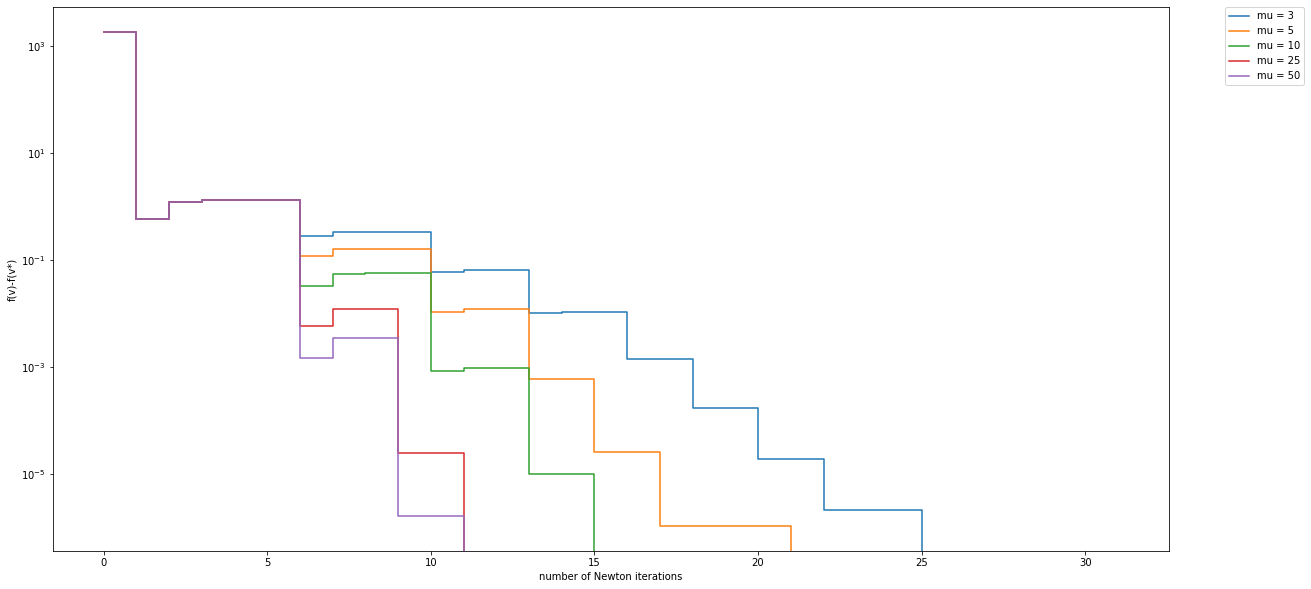

In [57]:
# On essaie différentes valeurs de mu
f = fct(listA,listb)
mus = [3,5,10,25,50]
plt.figure(figsize=(20,10))
for mu in mus:
    v = barr_method(listA, listb, z, R, d, v0,eps,crit,t0=1,mu=mu)[0]
    plt.step([i for i in range(len(v))],[f(u)-f(v[-1]) for u in v], label="mu = "+str(mu))
    plt.yscale("log")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylabel('f(v)-f(v*)')
plt.xlabel('number of Newton iterations')
plt.show()

(35, 35, 15)
(18375, 19) (18375,) 15 15 (1225, 19)


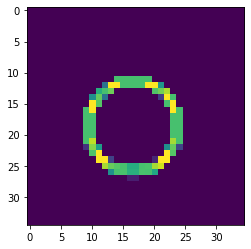

In [58]:
W = W_mat(particle,framesInter)
print(W.shape)
plt.imshow(W[:,:,10])

A, b, listA, listb = Create_A_and_b(W)
print(A.shape, b.shape, len(listA), len(listb), listA[0].shape)

In [59]:
# definis dans la simulation plus haut
R = Radius*zoomfactor
d = np.sqrt(nx**2+ny**2)
z = framesInter
print(R,d**2, z)
realcenter = center*nx


a = np.floor(realcenter)[0]
b = np.floor(realcenter)[1]
xsi = a**2+b**2+100
eta = 3*np.ones(len(z))
v0 = np.concatenate((np.floor(realcenter),[xsi],eta))
v0[0:3]+=0.8
print(realcenter)
print(v0)

eps=1e-6
crit=1e-6



8.0 2450.0 [12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
[19.23849954 17.01607495 19.76690988]
[ 19.8  17.8  19.8 750.    3.    3.    3.    3.    3.    3.    3.    3.
   3.    3.    3.    3.    3.    3.    3. ]


In [60]:
# Il faut bien initialiser

constr1 = v0[4:]
constr2 = -( (v0[2]-z)**2 - R**2)
constr3 = [-(v0[0]**2 + v0[1]**2 - v0[3])]
constr4 = [-(v0[3] - d**2)]
print(constr1)
print(constr2)
print(constr3)
print(constr4)

[3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
[ 3.16 17.76 30.36 40.96 49.56 56.16 60.76 63.36 63.96 62.56 59.16 53.76
 46.36 36.96 25.56]
[41.11999999999989]
[1700.0]


In [61]:
res = barr_method(listA, listb, z, R, d, v0,eps,crit,t0=1,mu=25)[0][-1]
print(res)


f(v) =  3057409.1756247617
f(v) =  105375.07084602224
f(v) =  105365.55858452783
f(v) =  105365.174737094
f(v) =  105365.15942683358
f(v) =  105365.15881274227
[1.87105838e+01 1.65378492e+01 1.84567543e+01 6.31101621e+02
 1.71336455e+01 1.34379426e+01 1.16443466e+01 8.80471893e+00
 7.08061847e+00 1.98763428e-09 3.45741180e-10 1.23610878e-10
 6.89125882e-11 4.88111673e-11 4.11250515e-11 3.90049179e-11
 4.17060519e-11 5.38814500e-11 1.00597490e-10]


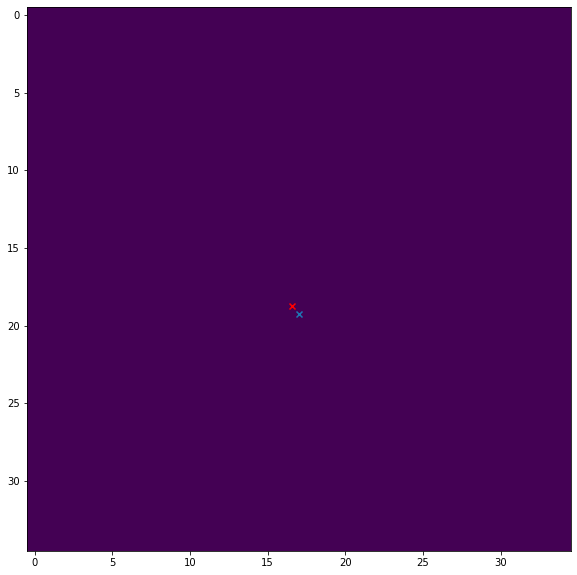

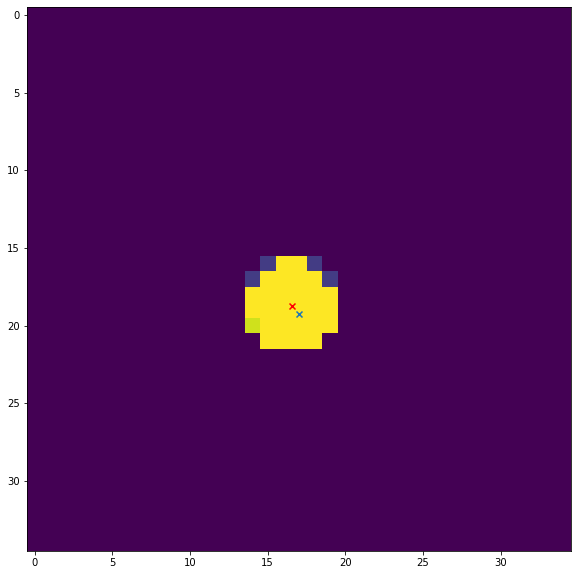

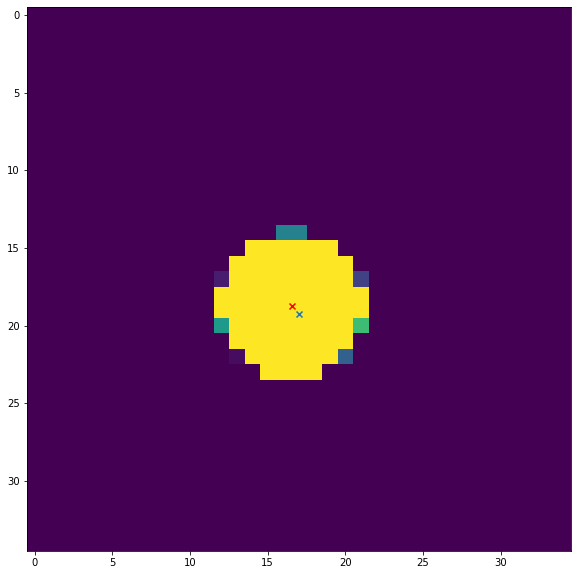

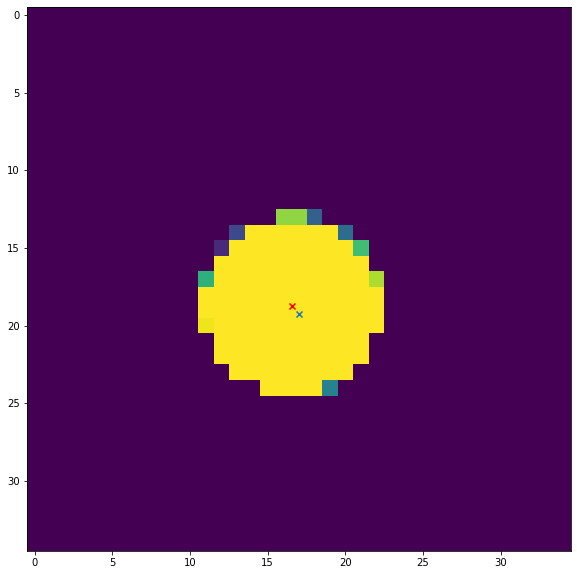

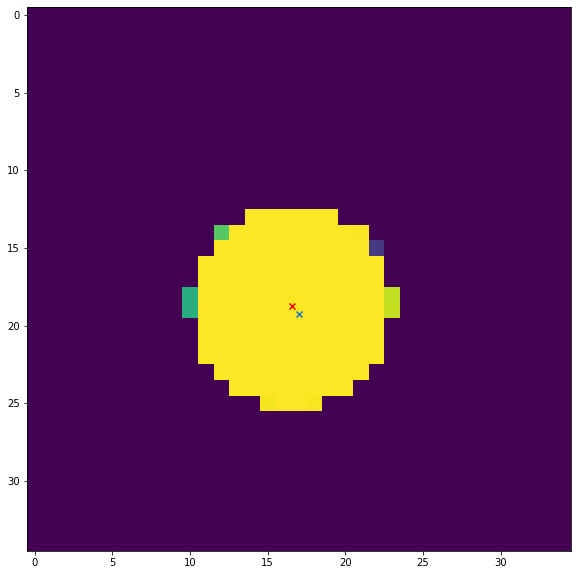

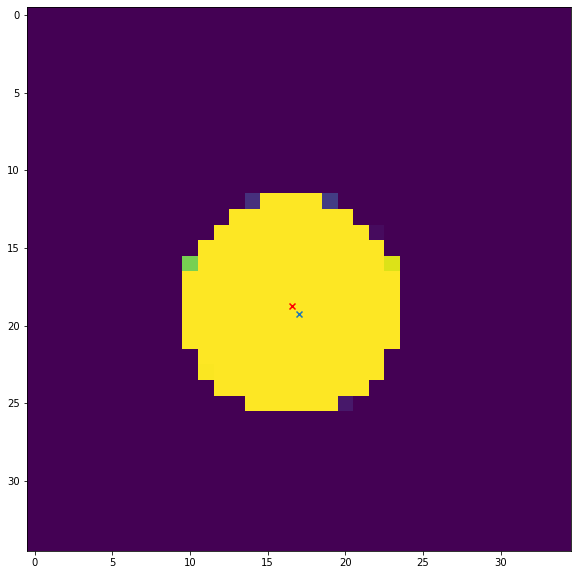

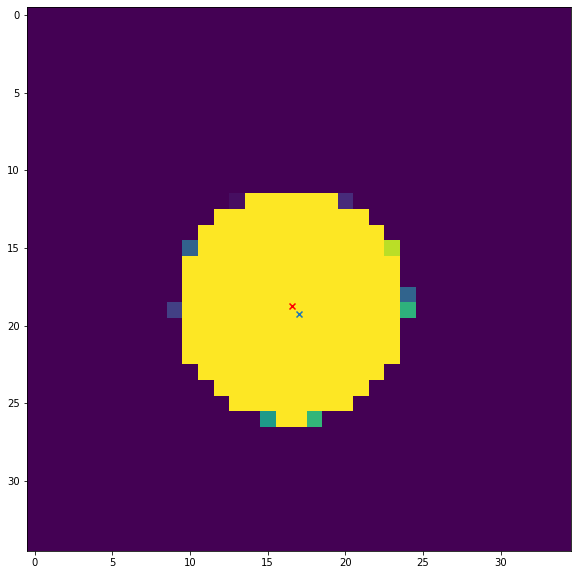

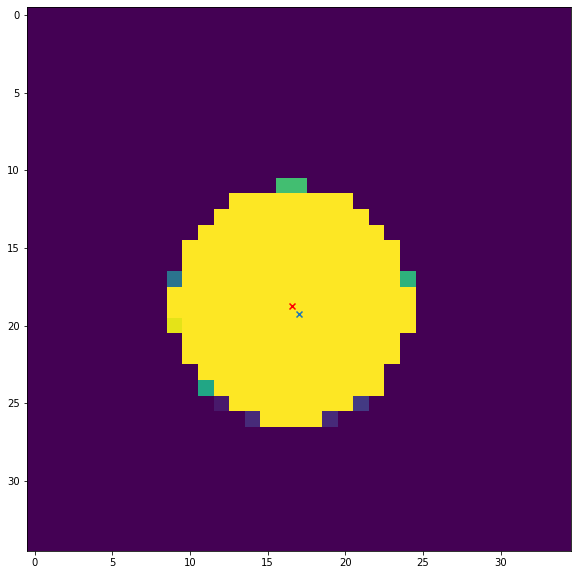

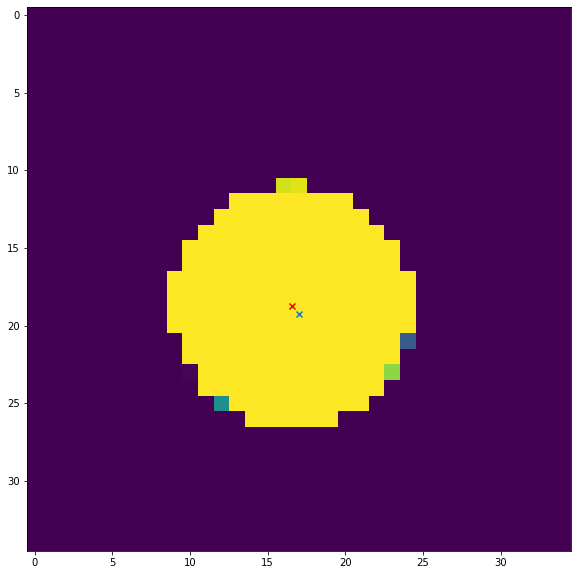

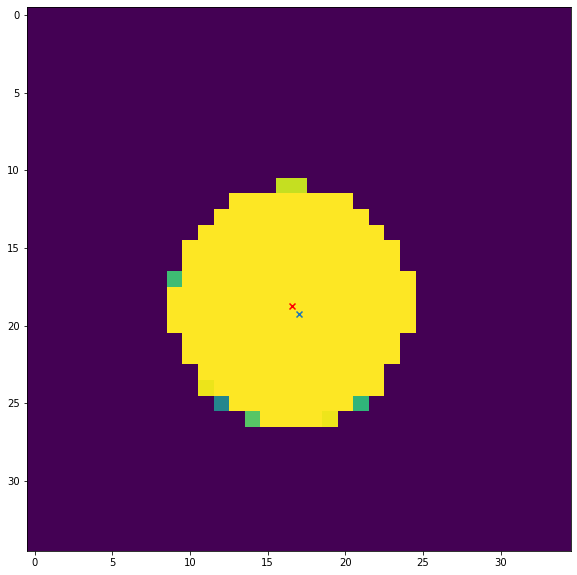

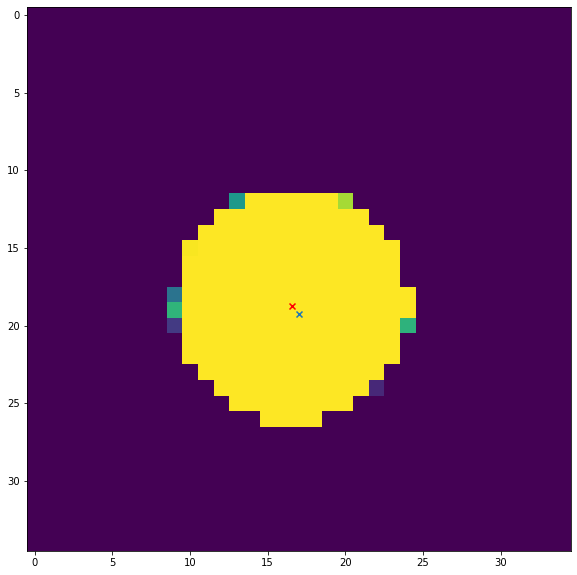

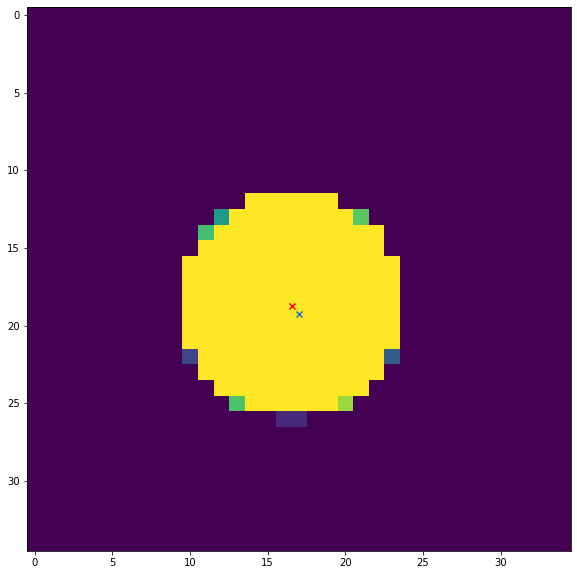

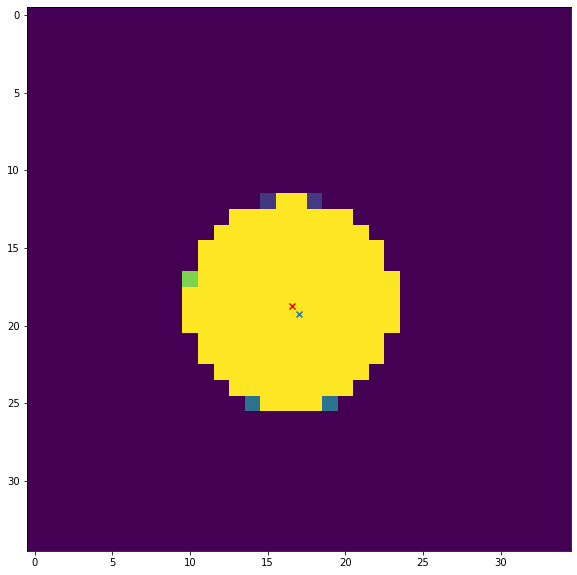

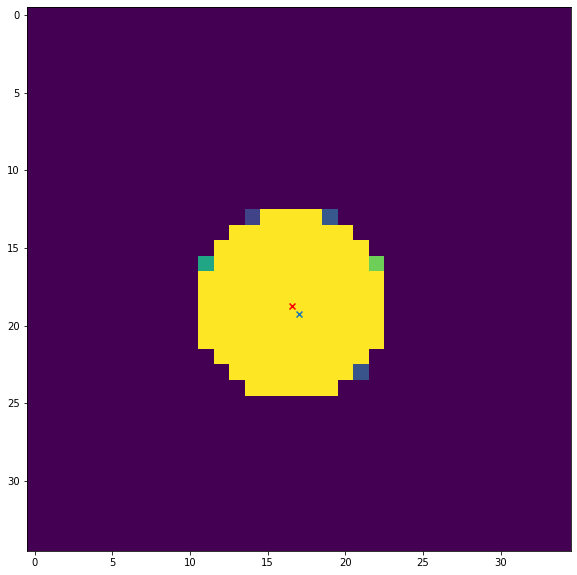

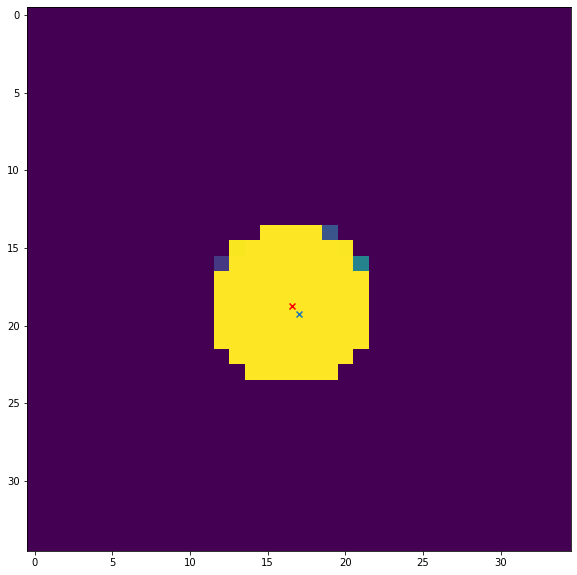

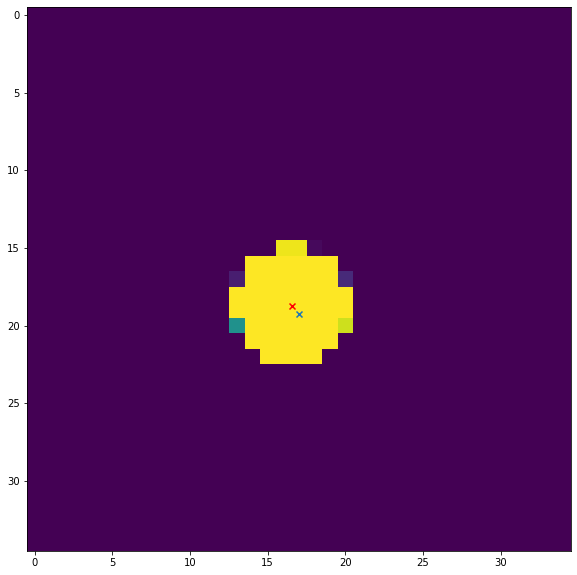

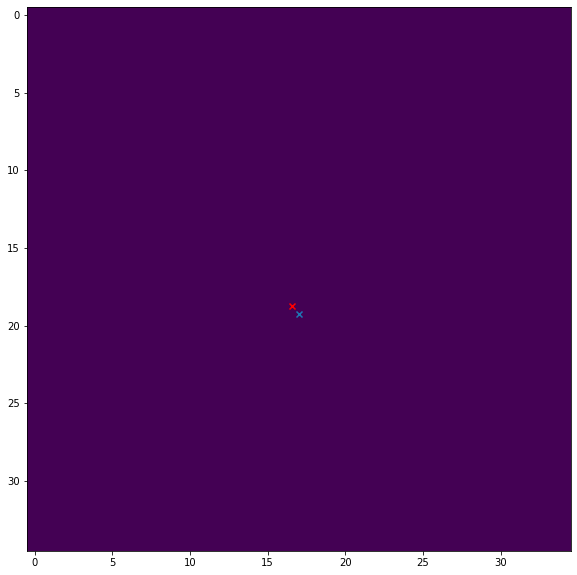

In [23]:
Z = int(nz*center[2])

for i in range(-8,9,1):
    plt.figure(figsize=(20,10))
    plt.imshow(particle[:,:,Z+i])
    plt.scatter([nx*center[1]],[ny*center[0]], marker="x")
    plt.scatter([res[1]],[res[0]], marker="x", color='red')
    plt.show()

DEBUG:matplotlib.ticker:vmin 2.3791058899752614e-07 vmax 1381178302.6837773
DEBUG:matplotlib.ticker:ticklocs array([1.e-09, 1.e-07, 1.e-05, 1.e-03, 1.e-01, 1.e+01, 1.e+03, 1.e+05,
       1.e+07, 1.e+09, 1.e+11, 1.e+13])
DEBUG:matplotlib.ticker:vmin 2.3791058899752614e-07 vmax 1381178302.6837773
DEBUG:matplotlib.ticker:ticklocs array([1.e-09, 1.e-07, 1.e-05, 1.e-03, 1.e-01, 1.e+01, 1.e+03, 1.e+05,
       1.e+07, 1.e+09, 1.e+11, 1.e+13])
DEBUG:matplotlib.ticker:vmin 2.3791058899752614e-07 vmax 1381178302.6837773
DEBUG:matplotlib.ticker:ticklocs array([1.e-09, 1.e-07, 1.e-05, 1.e-03, 1.e-01, 1.e+01, 1.e+03, 1.e+05,
       1.e+07, 1.e+09, 1.e+11, 1.e+13])
DEBUG:matplotlib.ticker:vmin 2.3791058899752614e-07 vmax 1381178302.6837773
DEBUG:matplotlib.ticker:vmin 2.3791058899752614e-07 vmax 1381178302.6837773
DEBUG:matplotlib.ticker:ticklocs array([1.e-09, 1.e-07, 1.e-05, 1.e-03, 1.e-01, 1.e+01, 1.e+03, 1.e+05,
       1.e+07, 1.e+09, 1.e+11, 1.e+13])
DEBUG:matplotlib.ticker:vmin 2.3791058899752

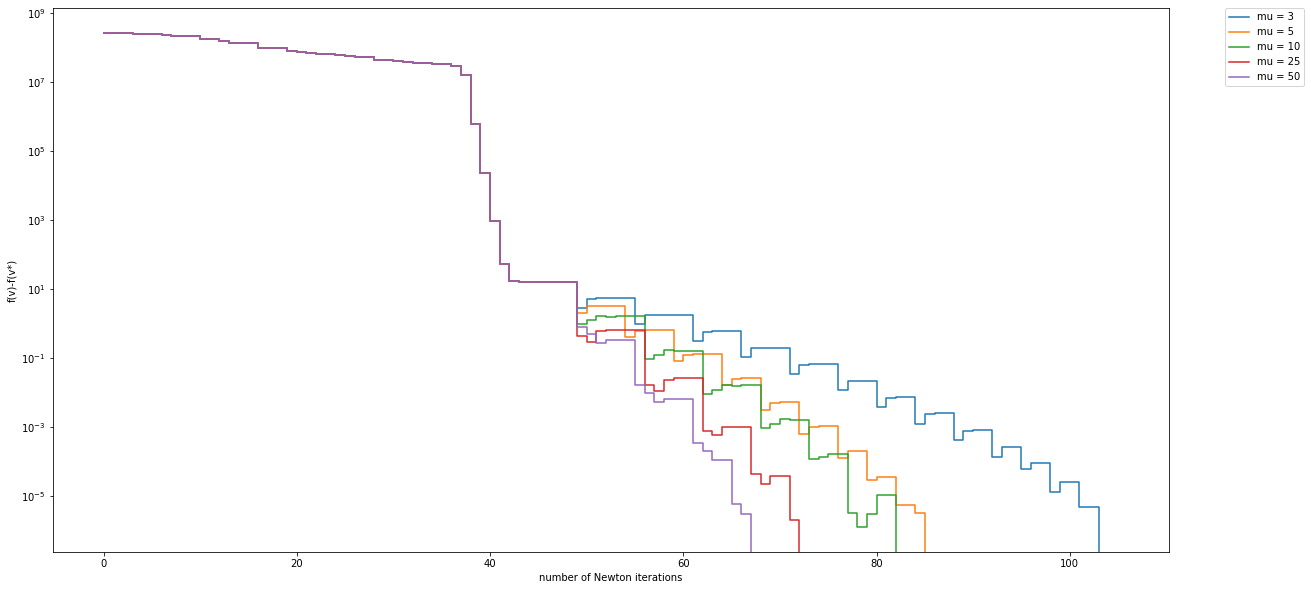

In [24]:
# On essaie différentes valeurs de mu
f = fct(listA,listb)
mus = [3,5,10,25,50]
plt.figure(figsize=(20,10))
for mu in mus:
    v = barr_method(listA, listb, z, R, d, v0,eps,crit,t0=1,mu=mu)[0]
    plt.step([i for i in range(len(v))],[f(u)-f(v[-1]) for u in v], label="mu = "+str(mu))
    plt.yscale("log")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylabel('f(v)-f(v*)')
plt.xlabel('number of Newton iterations')
plt.show()

## Matrices A and b for Moving particles

In [241]:
def Create_A_and_b_Moving_Patricle(W):
    "Cette fonction permet de creer la matrice A de taille n * 5m et le vecteur b de taille n"
    
    #Convertir la matrice W en 2D -- Taille: n * s(3) avec n = s(1)*s(2)
    s1 = np.size(W,0)
    s2 = np.size(W,1)
    s3 = np.size(W,2)
    
    W_2D = W.reshape(s1*s2, s3)

    
    # Definir les vecteurs x et y de taille n chacun
    x = np.zeros((s1*s2,1))
    y = np.zeros((s1*s2,1))
    for jj in range(s1*s2):
        x[jj] = np.floor((jj)/s1)
        y[jj] = np.mod(jj,s1)
  
# Definir un vecteur unite de taille n
    vecteur_unitaire = np.ones((s1*s2,1));    
        
    A = np.zeros((np.size(W_2D, 0), 5*s3, s3))
    b = np.zeros((np.size(W_2D, 0), s3));
    
    listA = [] #empty listA
    listb = []  #empty listb
    
    for kk in range(s3):
        #Definir le vecteur f_i de taille 5m (vecteur de 0 sauf le (i)th element est 1, avec i = 1, ... m)    
        f_i = np.zeros((5*s3,1))

        #Definir le vecteur f_m_i de taille 5m (vecteur de 0 sauf le (m+i)th element est 1, avec i = 1, ... m)
        f_m_i = np.zeros((5*s3,1))    

        #Definir le vecteur f_3m_i de taille 5m (vecteur de 0 sauf le (3m+i)th element est 1, avec i=1, ... m)
        f_3m_i = np.zeros((5*s3,1))

        #Definir le vecteur f_4m_i de taille 5m (vecteur de 0 sauf le (4m+i)th element est 1, avec i=1, ... m)
        f_4m_i = np.zeros((5*s3,1))  
        
        f_i[kk] = 1
        f_m_i[s3+kk] = 1
        f_3m_i[3*s3+kk] = 1
        f_4m_i[4*s3+kk] = 1
        
        A[:, :, kk] = np.diag(np.sqrt(W_2D[:, kk])) .dot(-2*np.kron(np.transpose(f_i), x) - 2*np.kron(np.transpose(f_m_i), y) + np.kron(np.transpose(f_3m_i), vecteur_unitaire) - np.kron(np.transpose(f_4m_i), vecteur_unitaire))
        listA.append(A[:, :, kk])
        
        b[:, kk] = np.multiply(-np.sqrt(W_2D[:, kk]), np.transpose(x**2)) + np.multiply(-np.sqrt(W_2D[:, kk]), np.transpose(y**2))
        listb.append(b[:, kk])
               
   #Concatenation dans une grande matrice (c'est important pour CVX)           
    permuted_A = np.transpose(A, (0, 2, 1))
    matrice_A = permuted_A.reshape(np.size(W_2D,0)*s3, 5*s3)
    vecteur_b = b.reshape(np.size(b,0) * np.size(b,1))
    
    return matrice_A, vecteur_b, listA, listb

## Moving Particle with CVX

In [131]:
def objective_function_reformulated_CVX_MOVING_particle(image,frames):
    import cvxpy as cp
       
    # Variables
    alpha = cp.Variable(mInter)
    beta = cp.Variable(mInter)
    gamma = cp.Variable(mInter)
    xi = cp.Variable(mInter)
    eta = cp.Variable(mInter)
    lambdaa = 1
    
    m = len(frames)
    W = W_mat(image,frames)
    A,b,listA,listb = Create_A_and_b_Moving_Patricle(W)
    
    #Definition de TV(alpha)
    TV_alpha = np.abs(alpha[1:] - alpha[:-1]).sum()

    #Definition de TV(beta)
    TV_beta = np.abs(beta[1:] - beta[:-1]).sum()

    #Definition de TV(xi)
    TV_xi = np.abs(xi[1:] - xi[:-1]).sum()

    #Definition de TV(gamma)
    TV_gamma = np.abs(gamma[1:] - gamma[:-1]).sum()
       
    
    cost = cp.sum_squares(A @ cp.hstack([alpha,beta,gamma,xi,eta]) - b)/2 + lambdaa*(TV_alpha + TV_beta + TV_xi + TV_gamma)

    # Constraints
    constraints = [alpha**2+beta**2-xi <= 0, xi - d**2 <= 0, -eta <= 0, eta+(gamma-framesInter)**2 - R**2 <= 0]
    
    prob = cp.Problem(cp.Minimize(cost), constraints)
    
    prob.solve(solver = cp.ECOS, verbose = True, max_iters=1000)
    
    print("Optimal value", prob.value)
    print("Status :", prob.status)

    print("alpha = ", alpha.value) 
    print("beta = ", beta.value) 
    print("gamma = ", gamma.value) 

    print("Real center: ", center*nx)

    Z = int(nz*center[2])

    for i in range(-8,9,2):
        plt.figure(figsize=(20,10))
        plt.imshow(particle[:,:,Z+i])
        plt.scatter([nx*center[1]],[ny*center[0]], marker="x")
        plt.scatter([beta.value],[alpha.value], marker="x", color='red')
        plt.show()
        
objective_function_reformulated_CVX_MOVING_particle(particle,framesInter) 

TypeError: bad operand type for abs(): 'AddExpression'

## Newton with moving particles and L2 regularization

In [272]:
import numpy as np
import matplotlib.pyplot as plt

# Centering step

# fonction à minimiser
def fct(listA, listb, lambd):
    m = len(listA)
    def f(v): 
        reg = np.sum((v[1:m]-v[0:m-1])**2) + np.sum((v[m+1:2*m]-v[m:2*m-1])**2) + np.sum((v[2*m+1:3*m]-v[2*m:3*m-1])**2)
        return np.sum([np.linalg.norm(listA[i]@v - listb[i])**2 for i in range(m)], axis=0)/2 + lambd*reg
    return f

# v = np.concatenate((alpha, beta, gamma, xsi, eta))


# Fonction avec barrière:
def fct_bar(listA, listb, z, R, d, t, lambd): # t est le paramètre de barrière
    m = len(listA)
    def f(v):
        constr1 = v[4*m:]
        constr2 = -(v[4*m:] + (v[2*m:3*m]-z)**2 - R**2)
        constr3 = -(v[0:m]**2 + v[1*m:2*m]**2 - v[3*m:4*m])
        constr4 = -(v[3*m:4*m] - d**2)
        constr = np.concatenate((constr1,constr2,constr3,constr4))
        reg = np.sum((v[1:m]-v[0:m-1])**2) + np.sum((v[m+1:2*m]-v[m:2*m-1])**2) + np.sum((v[2*m+1:3*m]-v[2*m:3*m-1])**2)
        if np.min(constr) <= 0:
            #raise NameError("v non admissible")
            return np.inf
        else:
            return np.sum([np.linalg.norm(listA[i]@v - listb[i])**2 for i in range(m)])/2 - (1/t)*np.sum(np.log(constr), axis=0) + lambd*reg
    return f



# Gradient en v de la fonction à minimiser
def grad_f(listA, listb, z, R, d, t, v, lambd):
    n=len(v)
    m = len(z)
    res = np.sum([listA[i].T@(listA[i]@v - listb[i]) for i in range(m)], axis=0)
    bar = np.zeros(n)
    # terme dû à la fonction barrière pour constr3 et constr4
    x = (-(v[0:m]**2 + v[1*m:2*m]**2 - v[3*m:4*m]))
    bar[0:m] += -2*v[0:m]/x
    bar[1*m:2*m] += -2*v[1*m:2*m]/x
    bar[3*m:4*m] += 1/x - 1/(d**2-v[3*m:4*m])
    x = R**2 - v[4*m:] - (v[2*m:3*m]-z)**2
    bar[2*m:3*m] += 2*(z-v[2*m:3*m])/x
    bar[4*m:] += 1/v[4*m:] - 1/x 
    # terme dû à la regularisation
    reggrad = np.zeros(n)
    reggrad[0] = -2*(v[1]-v[0])
    reggrad[m-1] = 2*(v[m-1]-v[m-2])
    reggrad[m] = -2*(v[m+1]-v[m])
    reggrad[2*m-1] = 2*(v[2*m-1]-v[2*m-2])
    reggrad[2*m] = -2*(v[2*m+1]-v[2*m])
    reggrad[3*m-1] = 2*(v[3*m-1]-v[3*m-2])  
    for i in range(1,m-1):
        reggrad[i] = -2*(v[i+1]-v[i]) + 2*(v[i]-v[i-1])  
        reggrad[m+i] = -2*(v[m+i+1]-v[m+i]) + 2*(v[m+i]-v[m+i-1]) 
        reggrad[2*m+i] = -2*(v[2*m+i+1]-v[2*m+i]) + 2*(v[2*m+i]-v[2*m+i-1])
    return res - bar/t + lambd*reggrad



# Hessienne
def hess_f(listA, listb, z, R, d, t, v, lambd):
    n=len(v)
    m = len(z)
    res = np.sum([listA[i].T@listA[i] for i in range(m)], axis=0)
    bar = np.zeros((n,n))
    for i in range(m):
        x = (-(v[i]**2 + v[m+i]**2 - v[3*m+i]))**2
        y = (R**2 - v[4*m+i] - (v[2*m+i]-z[i])**2)**2
        bar[i,i] += (-2*(v[3*m+i] - v[i]**2 - v[1*m+i]**2) - 4*v[i]**2)/x
        bar[m+i,m+i] += (-2*(v[3*m+i] - v[i]**2 - v[1*m+i]**2) - 4*v[1*m+i]**2)/x
        bar[2*m+i,2*m+i] += (-2*(R**2 - v[4*m+i] - (v[2*m+i]-z[i])**2) - 4*(v[2*m+i]-z[i])**2)/y
        bar[3*m+i,3*m+i] += -1/x - 1/(v[3*m+i]-d**2)**2
        bar[4*m+i,4*m+i] += -1/v[4*m+i]**2 - 1/y
        b = -4*v[i]*v[m+i]/x
        bar[i,m+i] += b
        bar[m+i,i] += b
        b = 2*v[i]/x
        bar[i,3*m+i] += b
        bar[3*m+i,i] += b
        b = 2*v[m+i]/x
        bar[m+i,3*m+i] += b
        bar[3*m+i,m+i] += b
        b = 2*(v[2*m+i]-z[i])/y
        bar[2*m+i,4*m+i] += b
        bar[4*m+i,2*m+i] += b
        # terme dû à la regularisation
        reghess = 4*np.eye(n) # les termes diagnonaux valent 2 ou 4                                                                         
        reghess[0,0] = 2
        reghess[m-1,m-1] = 2
        reghess[m,m] = 2
        reghess[2*m-1,2*m+1] = 2
        reghess[2*m,2*m] = 2
        reghess[3*m-1,3*m-1] = 2 
        for i in range(1,m-1):
            reghess[i,i-1] = -2
            reghess[i-1,i] = -2                                                                         
            reghess[i,i+1] = -2                                                                         
            reghess[i+1,i] = -2                                                                         
            reghess[m+i,m+i-1] = -2
            reghess[m+i-1,m+i] = -2 
            reghess[m+i+1,m+i] = -2
            reghess[m+i,m+i+1] = -2                                                                         
            reghess[2*m+i,2*m+i-1] = -2
            reghess[2*m+i-1,2*m+i] = -2                                                                         
            reghess[2*m+i+1,2*m+i] = -2
            reghess[2*m+i,2*m+i+1] = -2                                                                                                                           
    return  res - bar/t





# Backtracking line search
def lineSearch(f,x,delta,grad,alpha,beta,t=1): # 0<alpha<1/2 et 0<beta<1
    while f(x+t*delta) >= f(x) + alpha*t*(grad.T@delta) :
        t = beta*t
    return t

def graddesc(f,v,grad, t=1000):
    crit = True
    while crit:
        if f(v - t*grad) < f(v):
            v = v - t*grad
            crit = False
        t = t/2
    return v

# Centering step
# On retourne la liste des points et des decr pour les graphes à la fin
def centering_step(listA, listb, z, R, d, t, v0, crit, alpha = 0.4, beta = 0.9, lambd=0): # t et eps > 0
    # méthode de Newton
    res = [v0]
    v = v0
    decr = np.inf
    liste_decr=[]
    f = fct_bar(listA, listb, z, R, d, t,lambd)
    grad = grad_f(listA, listb, z, R, d, t, v, lambd)
    hess = hess_f(listA, listb, z, R, d, t, v, lambd)
    hess_inv = np.linalg.inv(hess)
    delta = -hess_inv@grad
    decr = grad.T@hess_inv@grad
    #print("decr = ",decr)
    #print(np.linalg.norm(grad))
    #while np.linalg.norm(grad) > crit:
    while decr/2 >= crit:
        v = v + lineSearch(f,v,delta,grad,alpha,beta)*delta
        #v = graddesc(f,v,grad)
        res.append(v)
        grad = grad_f(listA, listb, z, R, d, t, v, lambd)
        hess = hess_f(listA, listb, z, R, d, t, v, lambd)
        hess_inv = np.linalg.inv(hess)
        delta = -hess_inv@grad
        decr = grad.T@hess_inv@grad
        liste_decr.append(decr)
        print("decr = ",decr)
        #print(delta)
        #print("v_cent = ",v)
        #print("f_bar(v_cent) = ",f(v))
    return (res,liste_decr)


# Barrier method
# On retourne la liste des points et des decr pour les graphes à la fin
def barr_method(listA, listb, z, R, d, v0,eps, crit, alpha =0.4, beta = 0.9, t0 = 1, mu = 10, lambd=0): # t0, mu et eps > 0
    res = [v0]
    liste_decr = []
    n = len(v0)
    v = v0
    t = t0
    while n/t >= eps:
        #print("v = ",v)
        print("f(v) = ",fct(listA,listb,lambd)(v))
        (v, liste_decr_centering) = centering_step(listA, listb, z, R, d, t, v,crit, alpha, beta, lambd)
        liste_decr+= liste_decr_centering
        t = mu*t
        res = res + v
        v = v[-1]
    return (res,liste_decr)

In [273]:
#test

m = 4
listA = [np.eye(5*m) for i in range(m)]

#listA[0][2,2]=0
#listA[0][0,0]=0
#listA[0][1,1]=0
b = np.ones(5*m)*10
b[3*m:4*m] = 210


listb = [b for i in range(m)]
R=np.sqrt(110)+1
d=15
z = np.zeros(m)
v0 = np.ones(5*m)*6
v0[3*m:4*m]=150

eps=1e-6
crit=1e-3

v=barr_method(listA, listb, z, R, d, v0,eps,crit,t0=1,mu=10, lambd=20)[0][-1]
print(v)

f(v) =  29312.000000000004
decr =  1.5533950915878187
decr =  0.04430684607815884
decr =  2.246817278985217e-05
f(v) =  1.2625133895508995
decr =  0.0018070181693430414
f(v) =  0.02407071231976141
decr =  1.0844210243385773e-07
f(v) =  0.00041682119280313235
f(v) =  0.00041682119280313235
f(v) =  0.00041682119280313235
f(v) =  0.00041682119280313235
f(v) =  0.00041682119280313235
[  9.99515611   9.99515611   9.99515611   9.99515611   9.99515611
   9.99515611   9.99515611   9.99515611   9.9977305    9.9977305
   9.9977305    9.9977305  210.00007572 210.00007572 210.00007572
 210.00007572  10.0001404   10.0001404   10.0001404   10.0001404 ]


(35, 35, 15)
(18375, 75) (18375,) 15 15 (1225, 75)


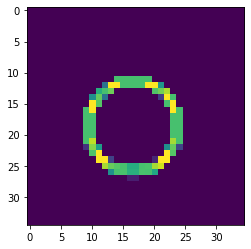

In [277]:
W = W_mat(particle,framesInter)
print(W.shape)
plt.imshow(W[:,:,10])

A, b, listA, listb = Create_A_and_b_Moving_Patricle(W)
print(A.shape, b.shape, len(listA), len(listb), listA[0].shape)

In [287]:
# definis dans la simulation plus haut
R = Radius*zoomfactor
d = np.sqrt(nx**2+ny**2)
z = framesInter
print(R,d**2, z)
realcenter = center*nx
m = len(z)

a = np.array([np.floor(realcenter)[0] for i in range(m)])
b = np.array([np.floor(realcenter)[1] for i in range(m)])
c = np.array([np.floor(realcenter)[2] for i in range(m)])
xsi = a**2+b**2+100
eta = 3*np.ones(m)
v0 = np.concatenate((a,b,c,xsi,eta))
#v0[0:3*m]+=0.8
print(realcenter)
print(len(v0))

eps=1e-6
crit=1

8.0 2450.0 [12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
[19.23849954 17.01607495 19.76690988]
75


In [288]:
# Il faut bien initialiser

constr1 = v0[4*m:]
constr2 = -(v0[4*m:] + (v0[2*m:3*m]-z)**2 - R**2)
constr3 = -(v0[0:m]**2 + v0[1*m:2*m]**2 - v0[3*m:4*m])
constr4 = -(v0[3*m:4*m] - d**2)
print(constr1)
print(constr2)
print(constr3)
print(constr4)

[3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
[12. 25. 36. 45. 52. 57. 60. 61. 60. 57. 52. 45. 36. 25. 12.]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100.]
[1700. 1700. 1700. 1700. 1700. 1700. 1700. 1700. 1700. 1700. 1700. 1700.
 1700. 1700. 1700.]


In [296]:
res = barr_method(listA, listb, z, R, d, v0,eps,crit,t0=1,mu=25, lambd=1e-4)[0][-1]
print(res[0:m], "mean = ", np.mean(res[0:m]))
print(res[m:2*m],"mean = ", np.mean(res[m:2*m]))
print(res[2*m:3*m],"mean = ", np.mean(res[2*m:3*m]))
print(res[3*m:4*m])
print(res[4*m:])

f(v) =  12839944.268961743
decr =  4296437.24272603
decr =  2851683.904873658
decr =  1209981.8674455753
decr =  43700.120616561246
decr =  11.906217322261075
decr =  6.5205757012238275
decr =  3.2180372403646125
decr =  1.5141453079714757
f(v) =  29101.98748683146
f(v) =  29101.98748683146
f(v) =  29101.98748683146
f(v) =  29101.98748683146
f(v) =  29101.98748683146
decr =  7.960573198793526
decr =  3.110808687515842
decr =  2.647919699144076
decr =  2.208229934013829
decr =  2.21232794560924
decr =  1.6020645916101728
[18.71108974 18.73268084 18.71448341 18.82090242 18.7031073  18.7280198
 18.67553668 18.78884401 18.75097468 18.69890232 18.61225245 18.60709222
 18.59771001 18.63549446 18.67907545] mean =  18.697077719137905
[16.50413344 16.53348473 16.55649709 16.53898771 16.50932362 16.5613331
 16.52414404 16.54995601 16.51894031 16.56999867 16.51963079 16.50703247
 16.52282995 16.52314547 16.53024312] mean =  16.53131203576252
[14.22170909 14.29513265 14.83893463 15.33320616 16.120

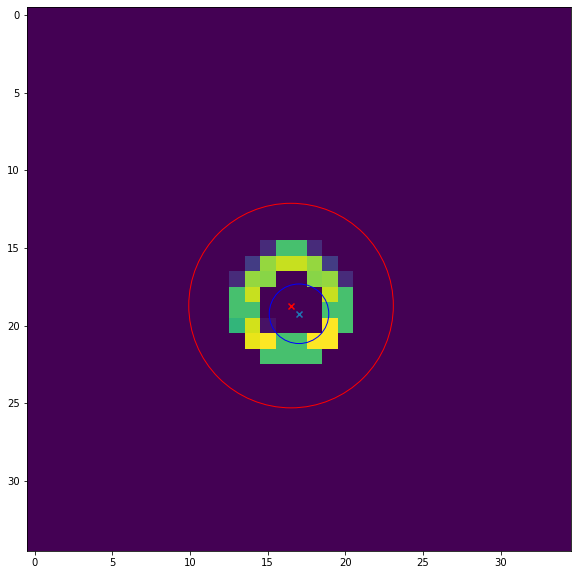

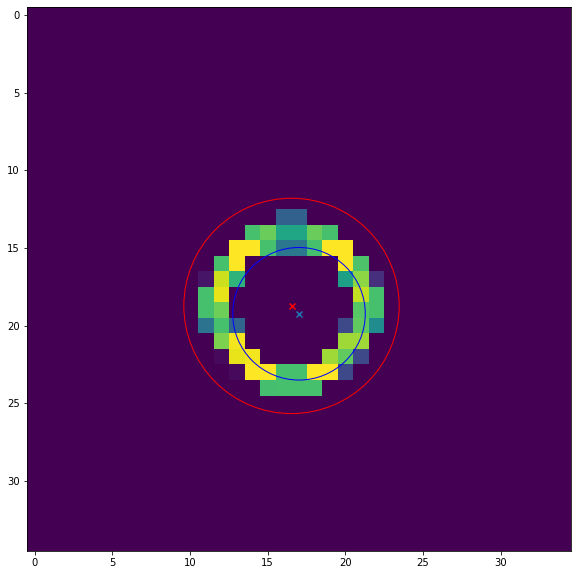

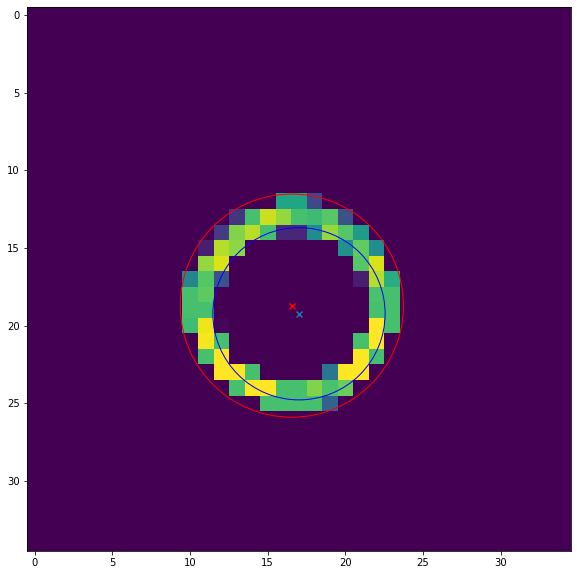

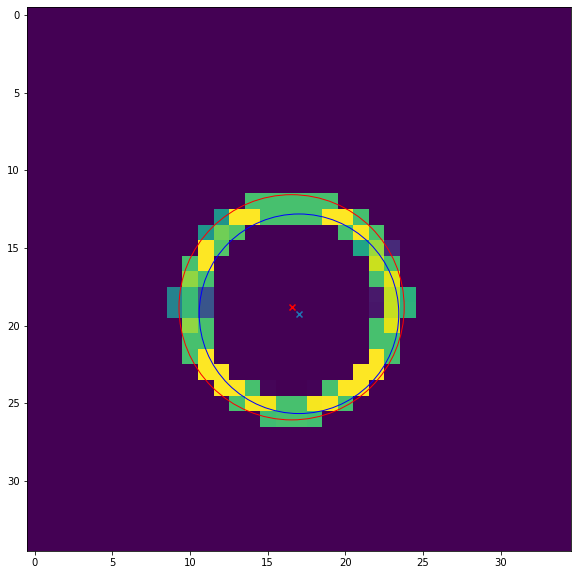

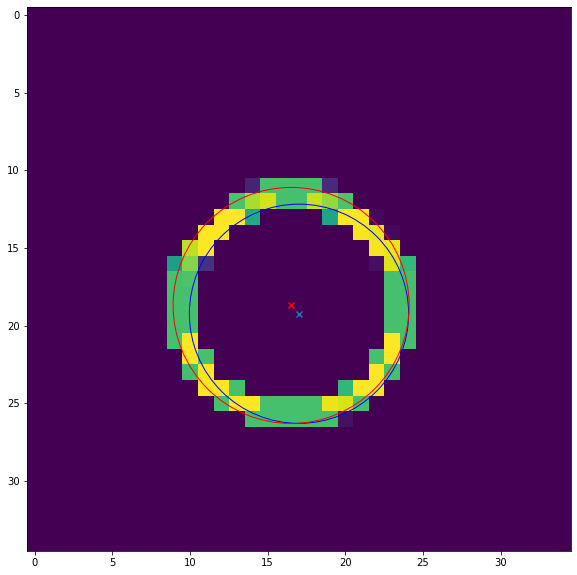

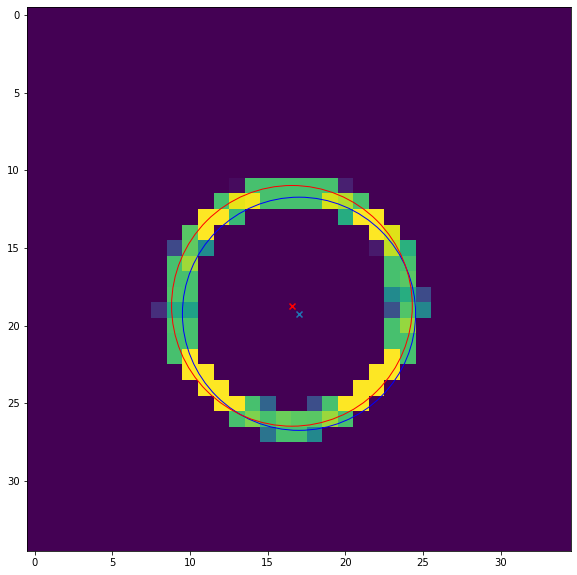

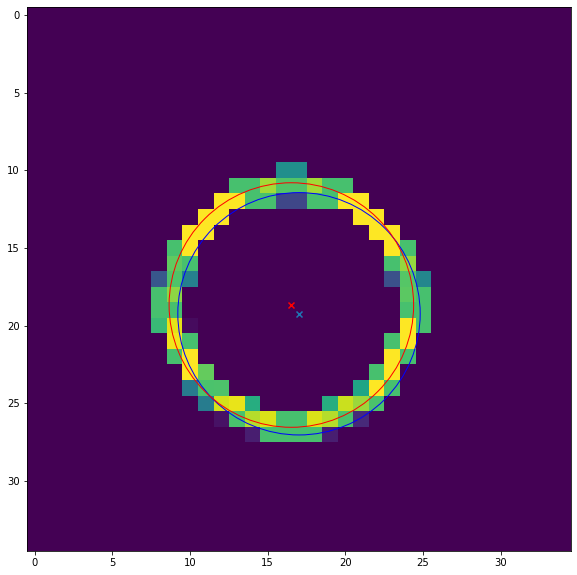

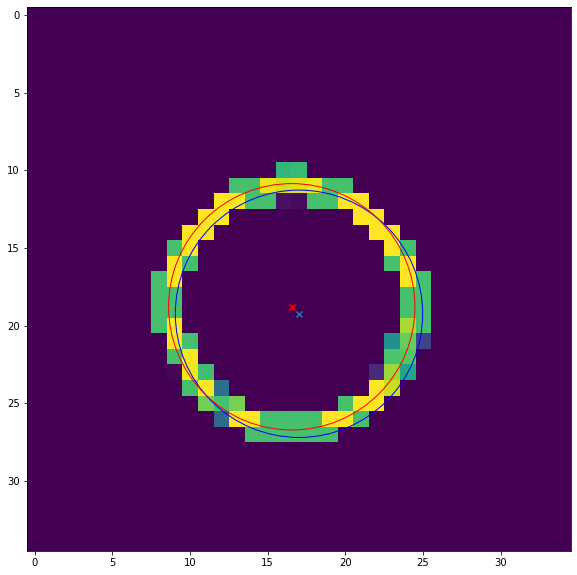

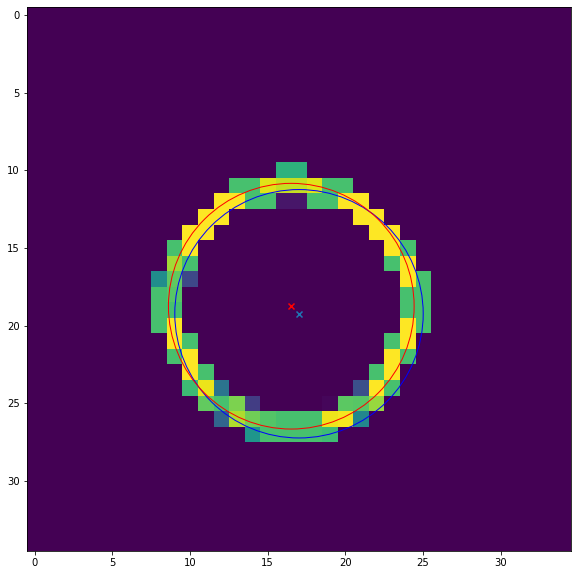

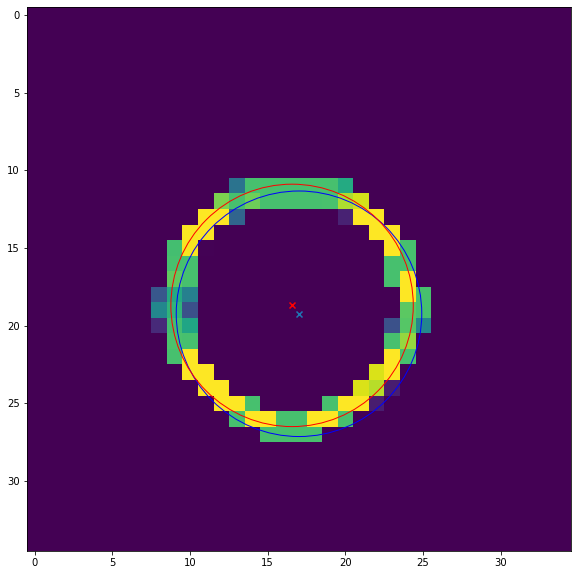

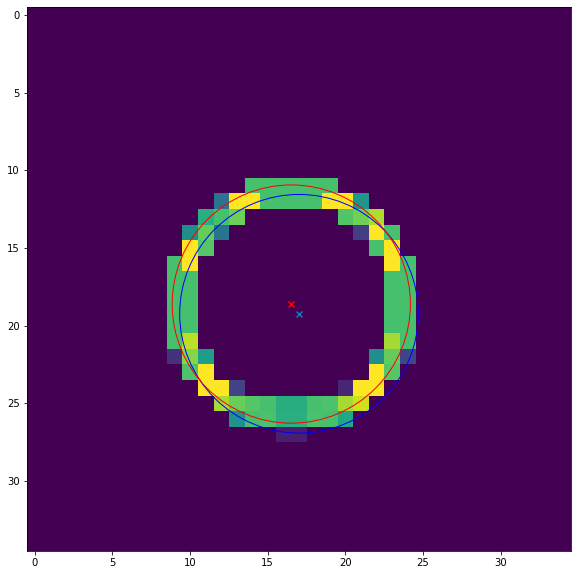

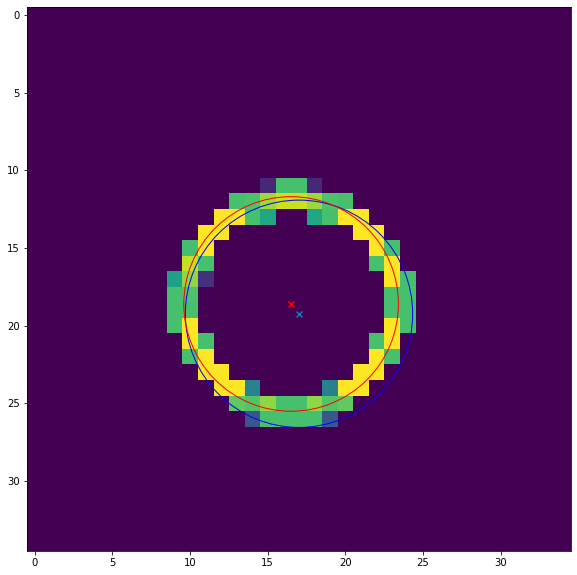

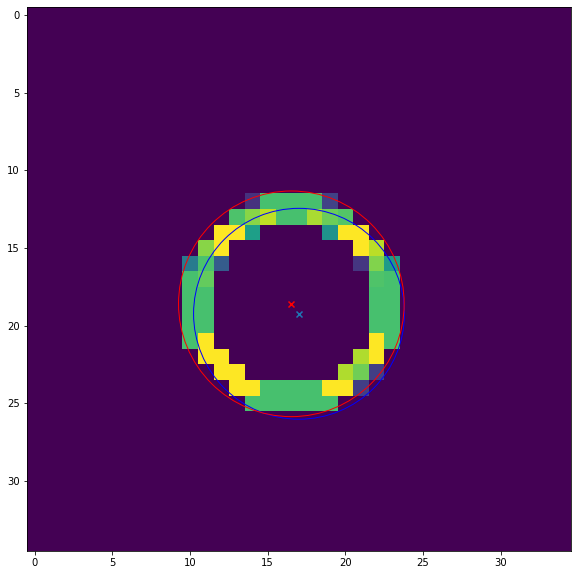

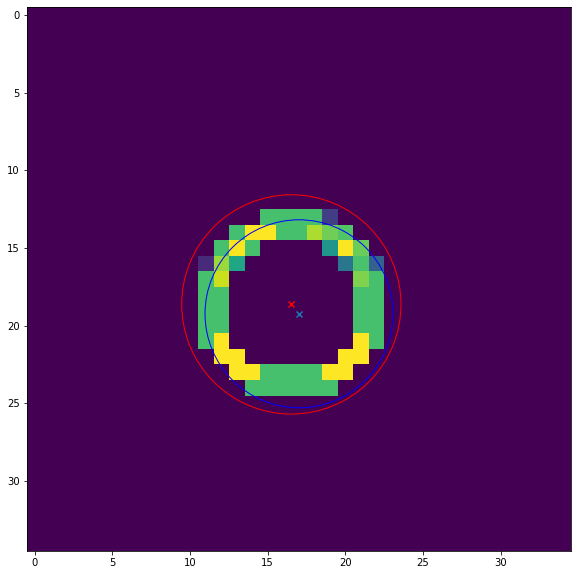

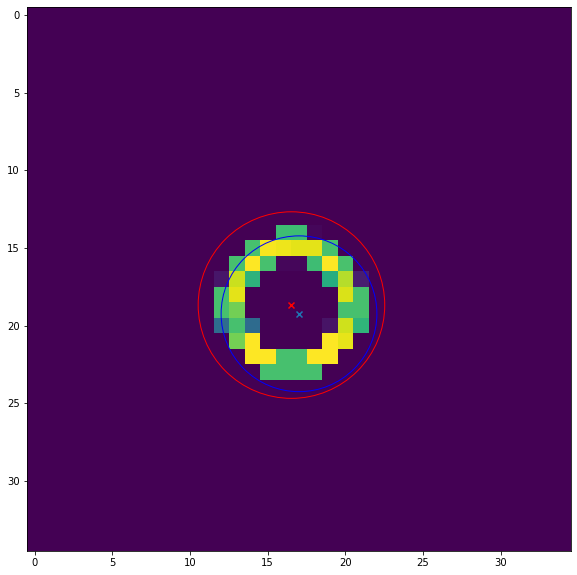

In [295]:
Z = int(nz*center[2])

for i in range(m):
    plt.figure(figsize=(20,10))
    plt.imshow(W[:,:,i])
    draw_circle = plt.Circle((realcenter[1], realcenter[0]), np.sqrt(R**2-(realcenter[2]-z[i])**2),fill=False,color='blue')
    plt.gcf().gca().add_artist(draw_circle)
    plt.scatter([nx*center[1]],[ny*center[0]], marker="x")
    plt.scatter([res[m+i]],[res[i]], marker="x", color='red')
    draw_circle = plt.Circle((res[m+i], res[i]), np.sqrt(res[4*m+i]),fill=False,color='red')
    plt.gcf().gca().add_artist(draw_circle)
    plt.show()